# Predicting Abalone Age

Abalones are a rare type of marine snail found in cold coastal saltwater and highly valued for their culinary uses. It’s popularity has led to overharvesting, rendering it even rarer and more expensive. Assessing the age of these organisms is a tedious task that requires cutting open the snail’s shell, staining it, and counting the individual rings under a microscope. Therefore, we wish to design a model that will **predict their age** through other measurements, such as physical dimensions and weight.

The [dataset](https://archive.ics.uci.edu/ml/datasets/Abalone) contains 4,177 observations and 9 columns: sex (either M, F, or I for infant); length, diameter, and height in mm; whole weight, shucked weight (without shell), viscera weight (after bleeding), and shell weight in grams; and number of rings (approximately 1.5 less than the age). After the design of the model, we will evaluate the accuracy of our predictions to answer the question: how well can we predict the age of an abalone snail from its size, sex, and weight?

## Setup code

In [3]:
library(tidyverse)
library(tidymodels)
library(repr)
download.file('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', 'data.csv')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Loading and wrangling data

In [4]:
set.seed(695624153)
abalone <- read_csv('data.csv', col_names = c(
    'sex',
    'length',
    'diameter',
    'height',
    'whole_weight',
    'shucked_weight',
    'viscera_weight',
    'shell_weight',
    'rings'
))

abalone <- abalone %>%
    mutate(sex = as_factor(sex)) %>%
    mutate(age = rings + 1.5)

abalone_split <- initial_split(abalone, prop = 0.75, strata = age)
abalone_training <- training(abalone_split)
abalone_testing <- testing(abalone_split) # delete this later if not needed

abalone_male <- abalone %>%
    filter(sex == "M")

abalone_female <- abalone %>%
    filter(sex == "F")

abalone_infant <- abalone %>%
    filter(sex =="I")

abalone_split_male <- initial_split(abalone_male, prop = 0.75, strata = age)
abalone_training_male <- training(abalone_split_male)
abalone_testing_male <- testing(abalone_split_male)

abalone_split_female <- initial_split(abalone_female, prop = 0.75, strata = age)
abalone_training_female <- training(abalone_split_female)
abalone_testing_female <- testing(abalone_split_female)

abalone_split_infant <- initial_split(abalone_infant, prop = 0.75, strata = age)
abalone_training_infant <- training(abalone_split_infant)
abalone_testing_infant <- testing(abalone_split_infant)

Parsed with column specification:
cols(
  sex = col_character(),
  length = col_double(),
  diameter = col_double(),
  height = col_double(),
  whole_weight = col_double(),
  shucked_weight = col_double(),
  viscera_weight = col_double(),
  shell_weight = col_double(),
  rings = col_double()
)



## Summarization

Table 1: The number of each amount of rings present in the dataset (mean = 9.934). This is the variable which we aim to predict.

In [5]:
age_counts <- abalone %>%
    group_by(rings) %>%
    summarize(n = n())
age_counts

`summarise()` ungrouping output (override with `.groups` argument)



rings,n
<dbl>,<int>
1,1
2,1
3,15
4,57
5,115
6,259
7,391
8,568
9,689


Table 2: The mean values of each numerical predictor in the data set.

In [6]:
predictor_means <- abalone %>%
    select(-rings) %>%
    summarize(across(length:shell_weight, mean))
predictor_means

length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5239921,0.4078813,0.1395164,0.8287422,0.3593675,0.1805936,0.2388309


Table 3: The mean values of each predictor with regards to sex of the abalone. From this table we observe that females are generally slightly larger and heavier than males, and both are larger and heavier than infants.

In [7]:
sex_means <- abalone %>%
    group_by(sex) %>%
    summarize(across(length:shell_weight, mean))
sex_means

`summarise()` ungrouping output (override with `.groups` argument)



sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.5613907,0.4392866,0.1513809,0.9914594,0.4329460,0.21554450,0.2819692
F,0.5790933,0.4547322,0.1580107,1.0465321,0.4461878,0.23068860,0.3020099
I,0.4277459,0.3264940,0.1079955,0.4313625,0.1910350,0.09201006,0.1281822


## Visualization

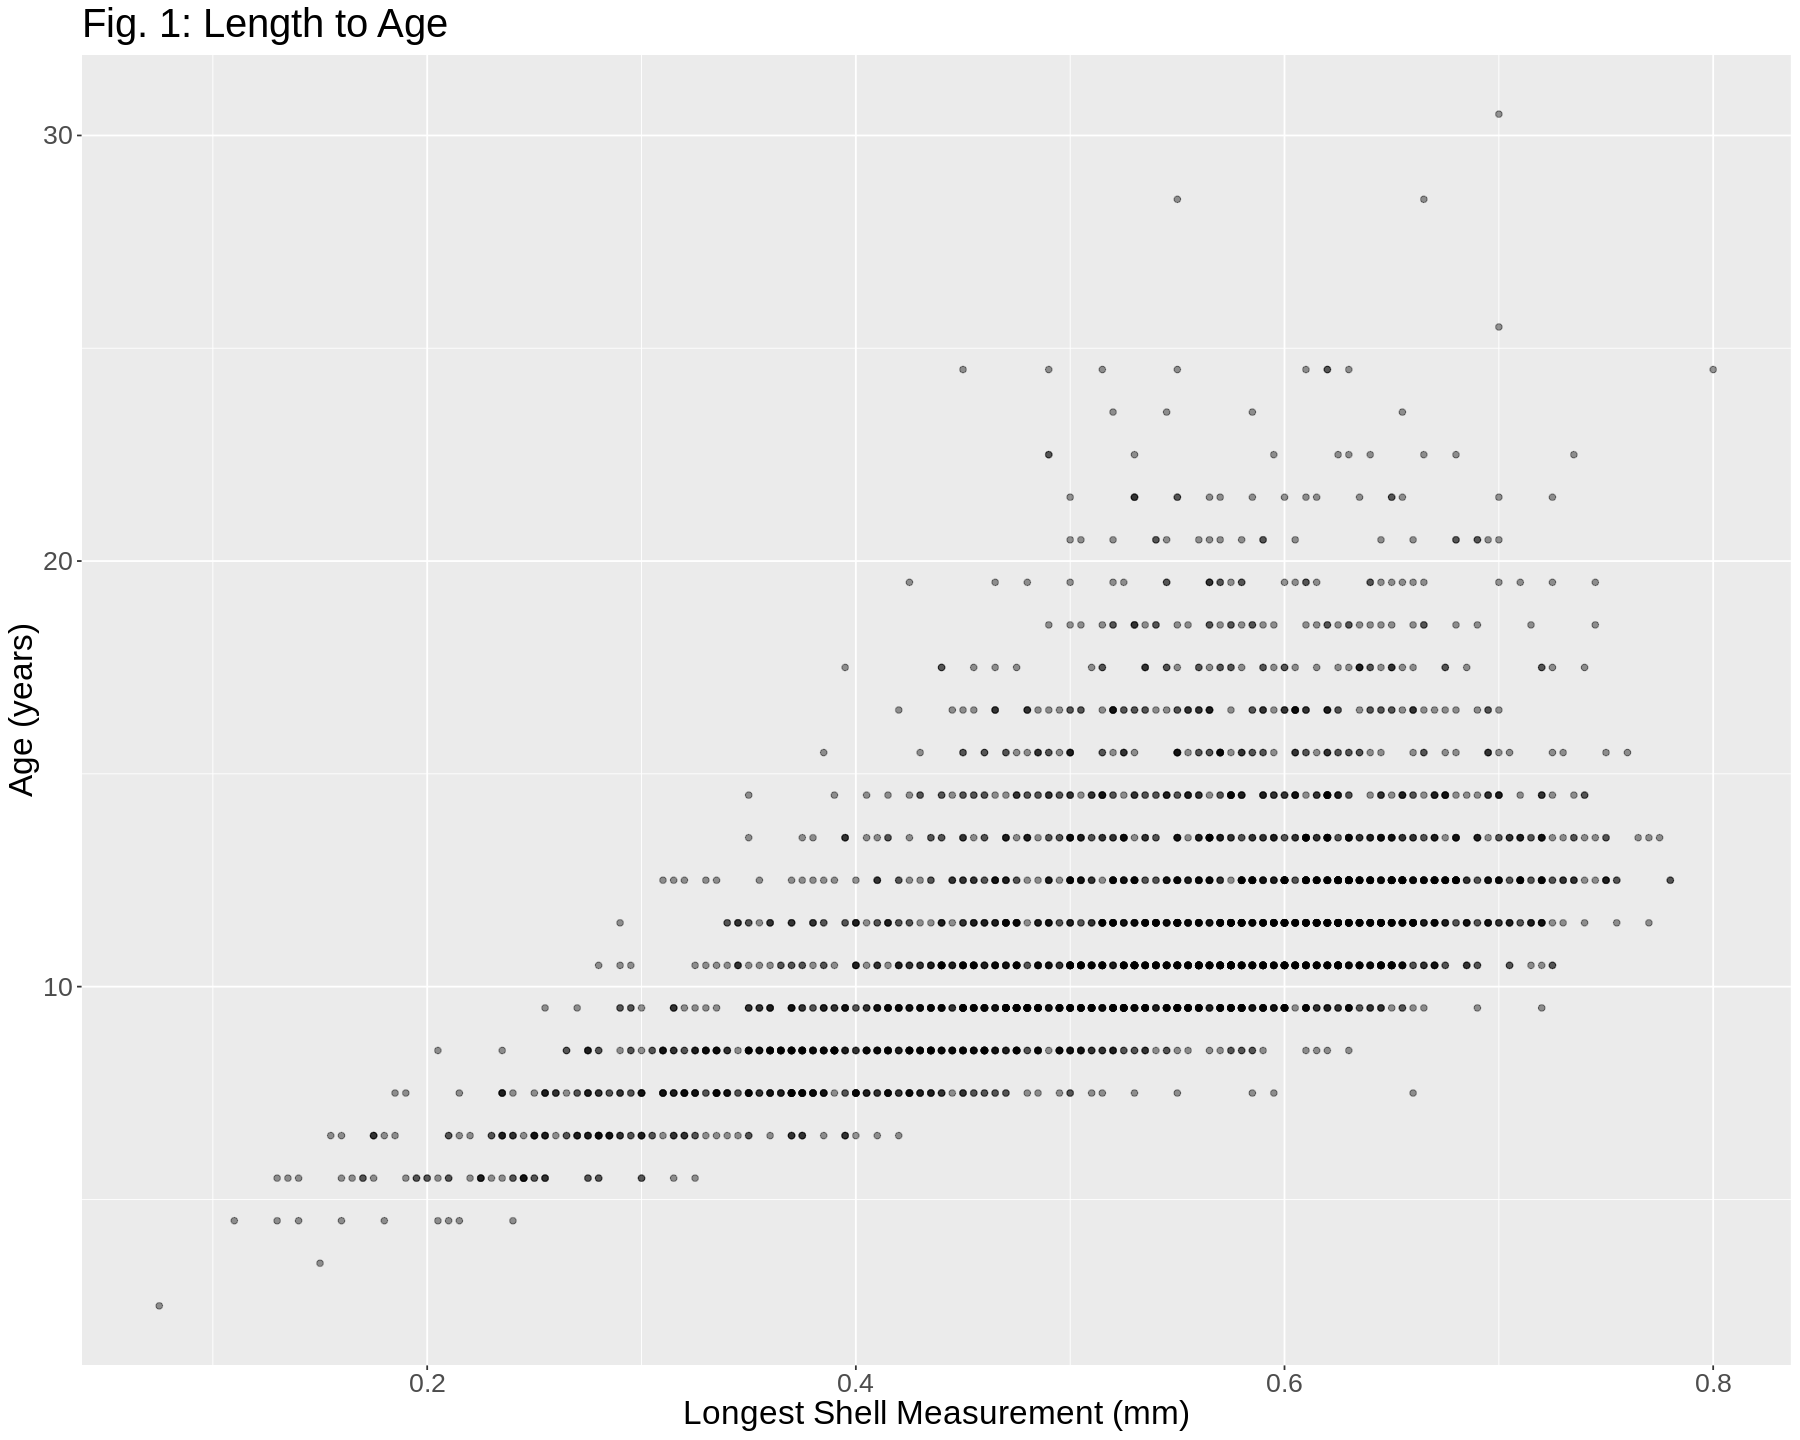

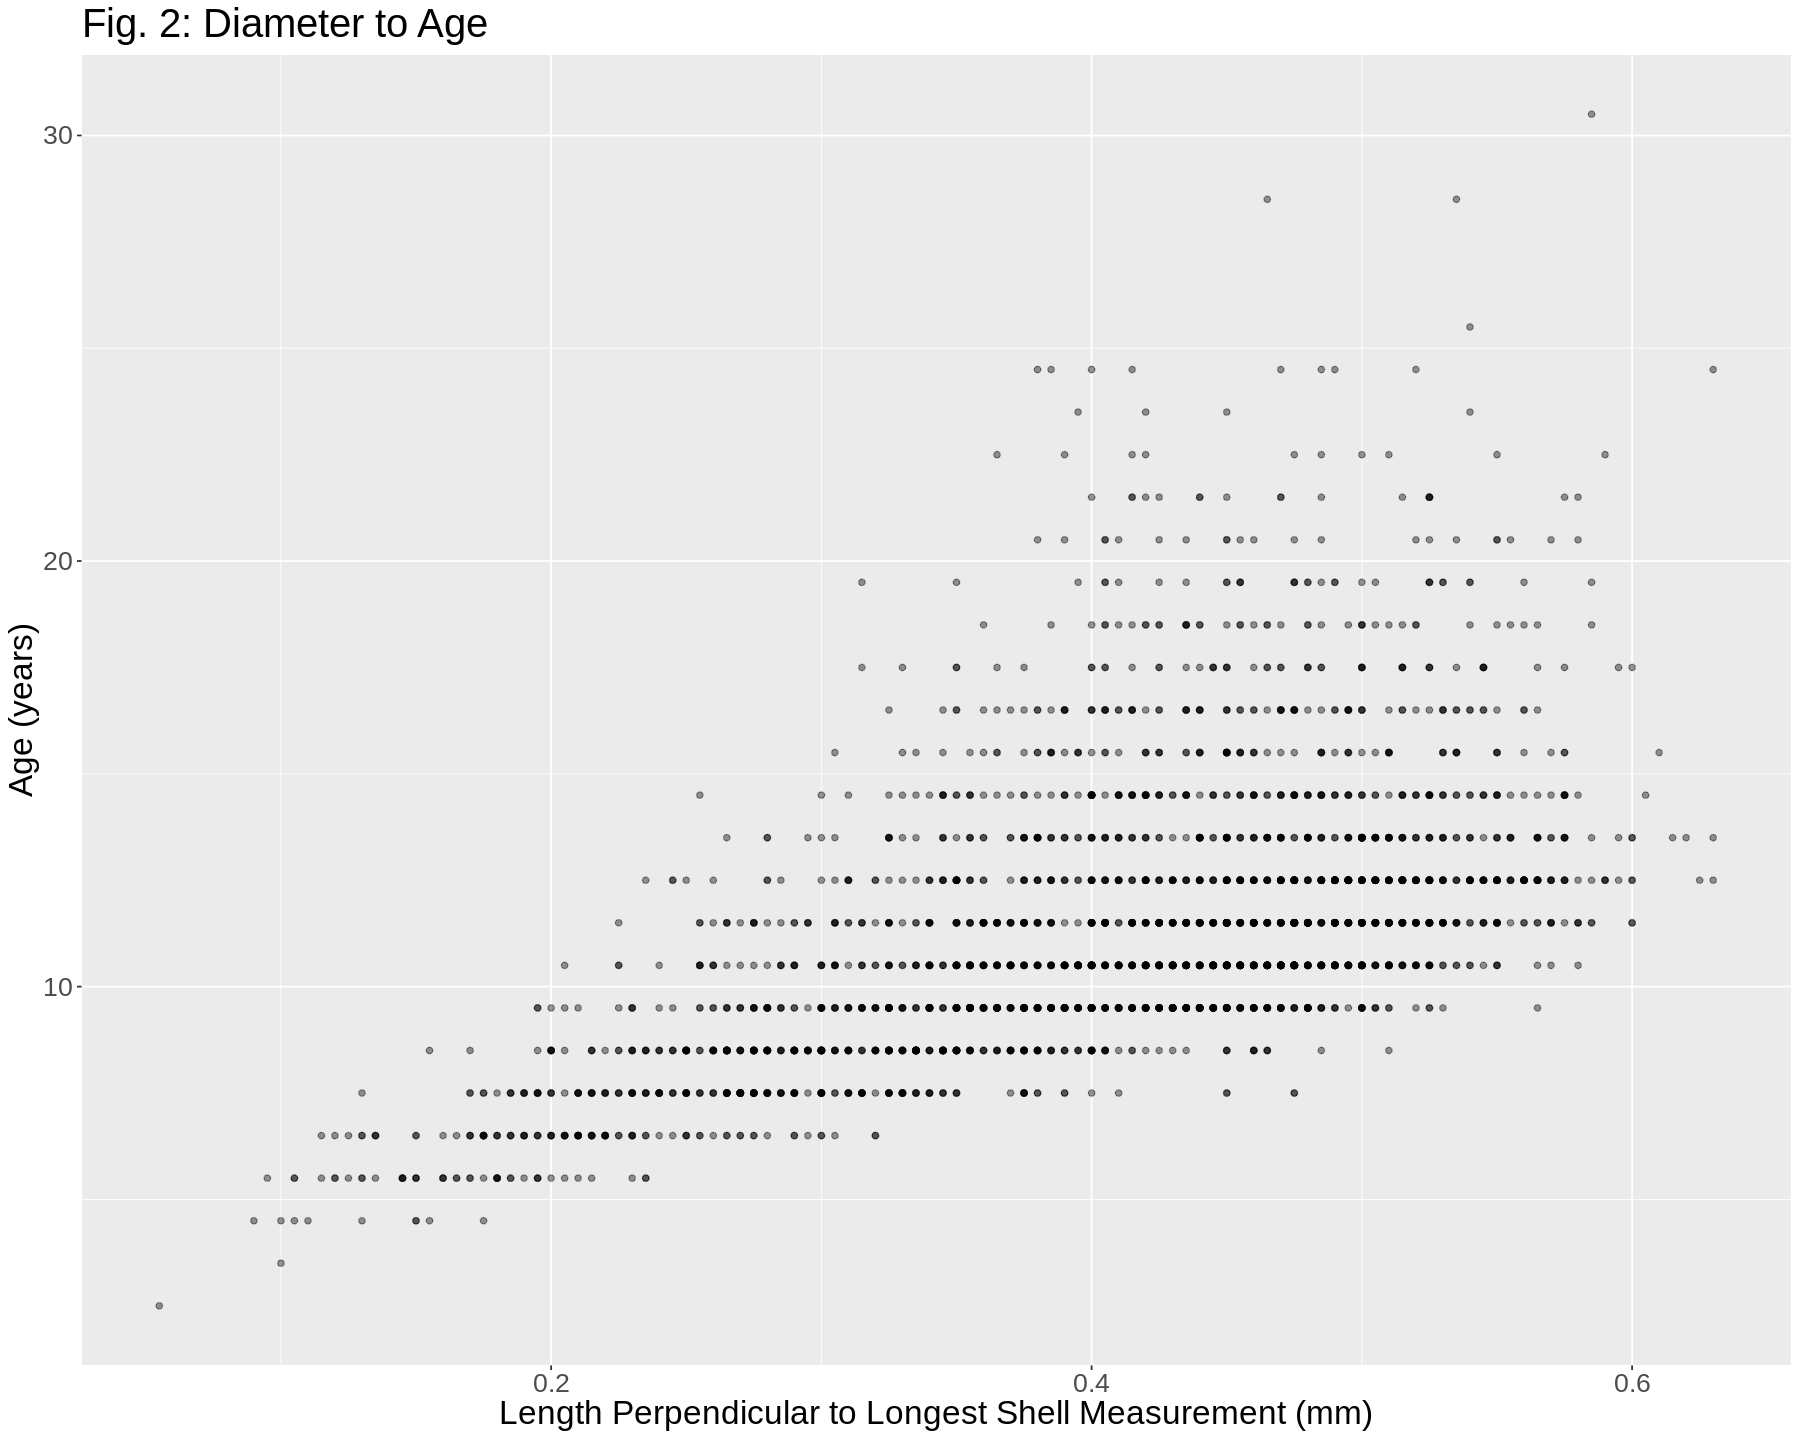

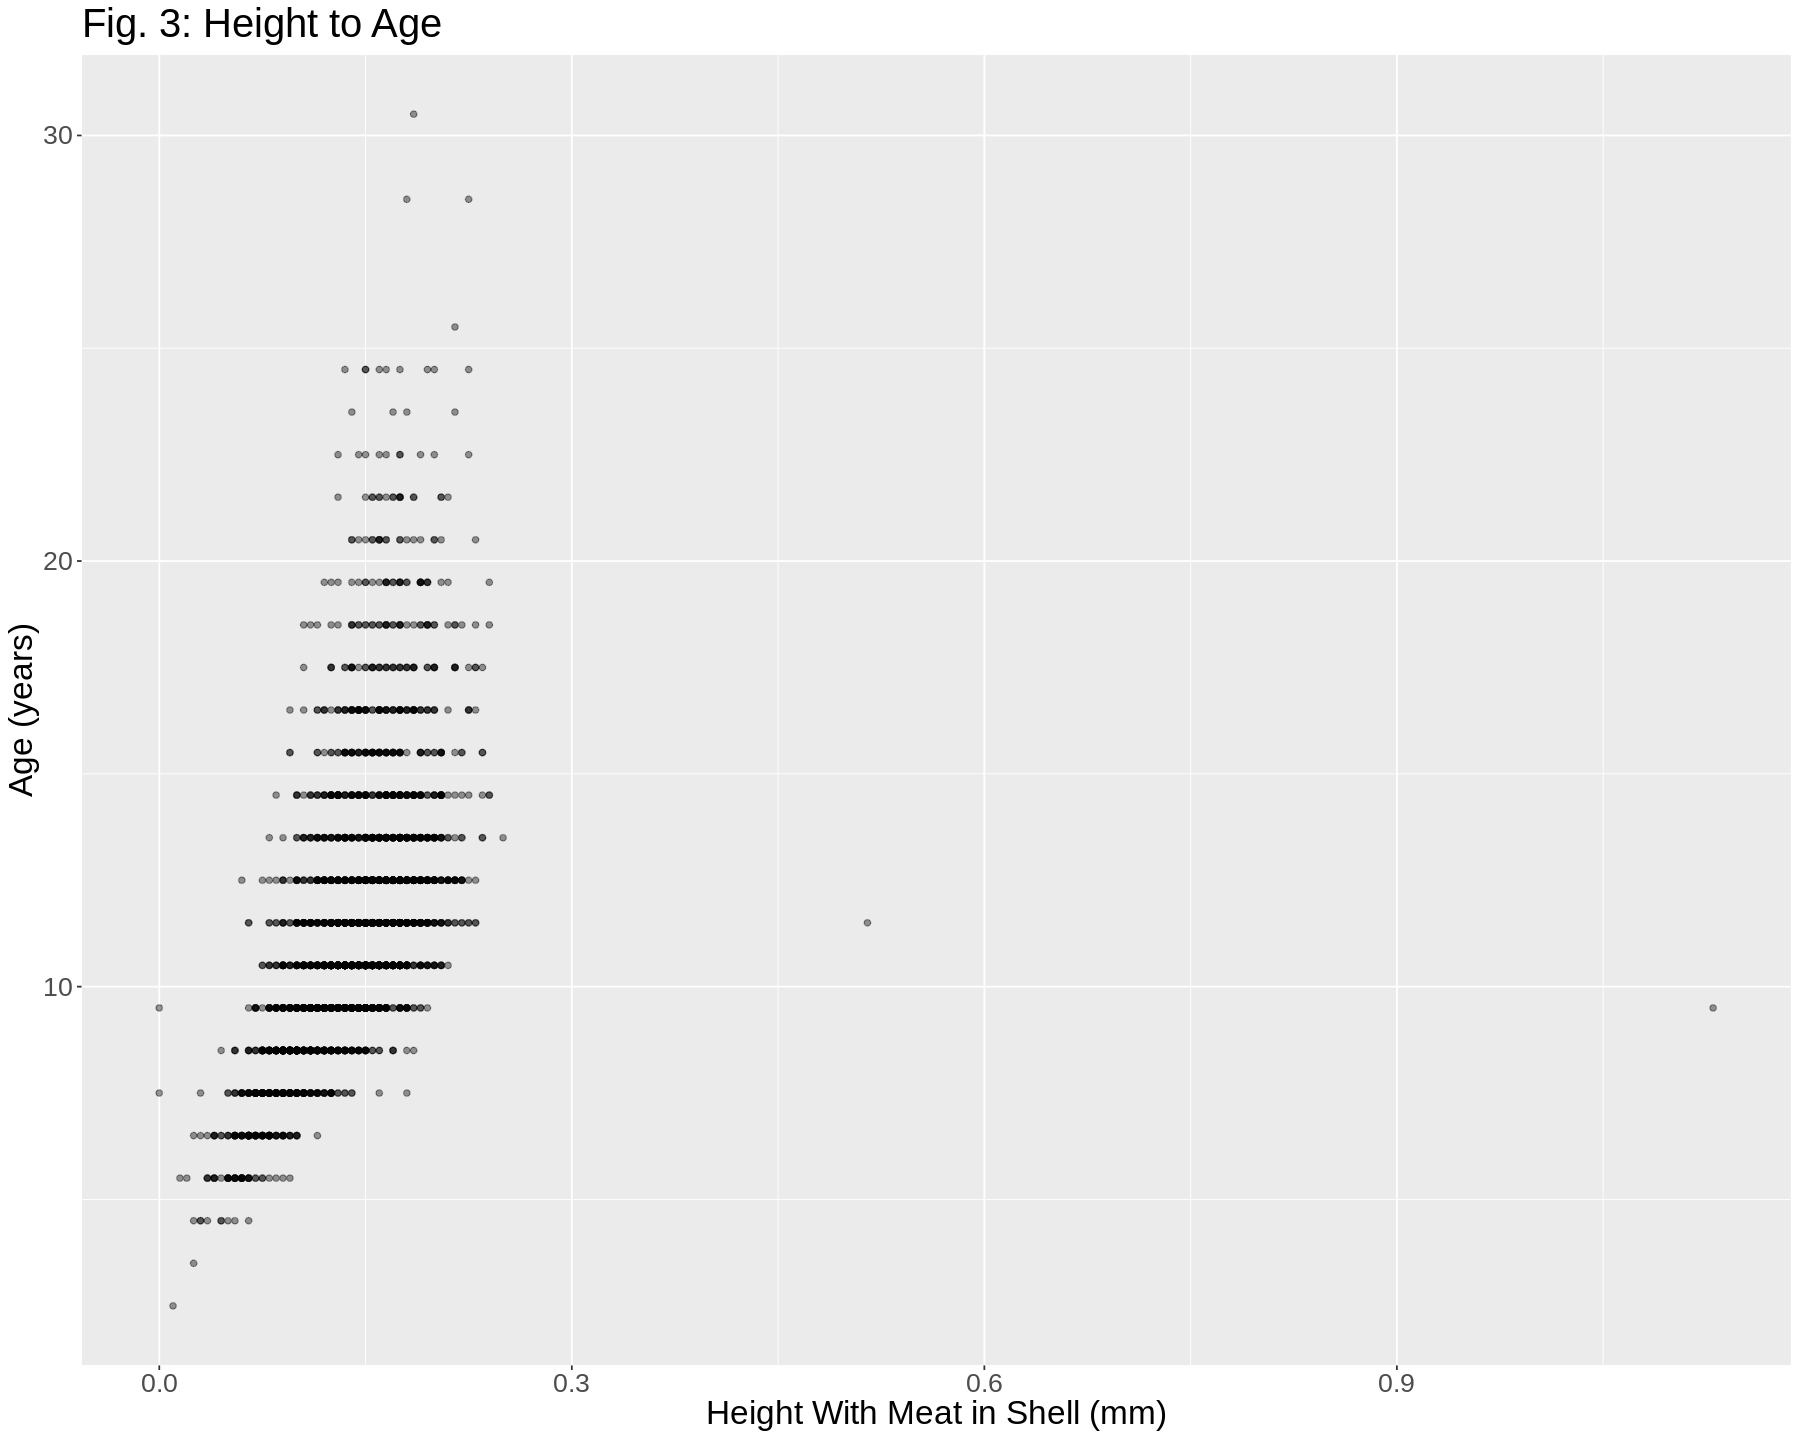

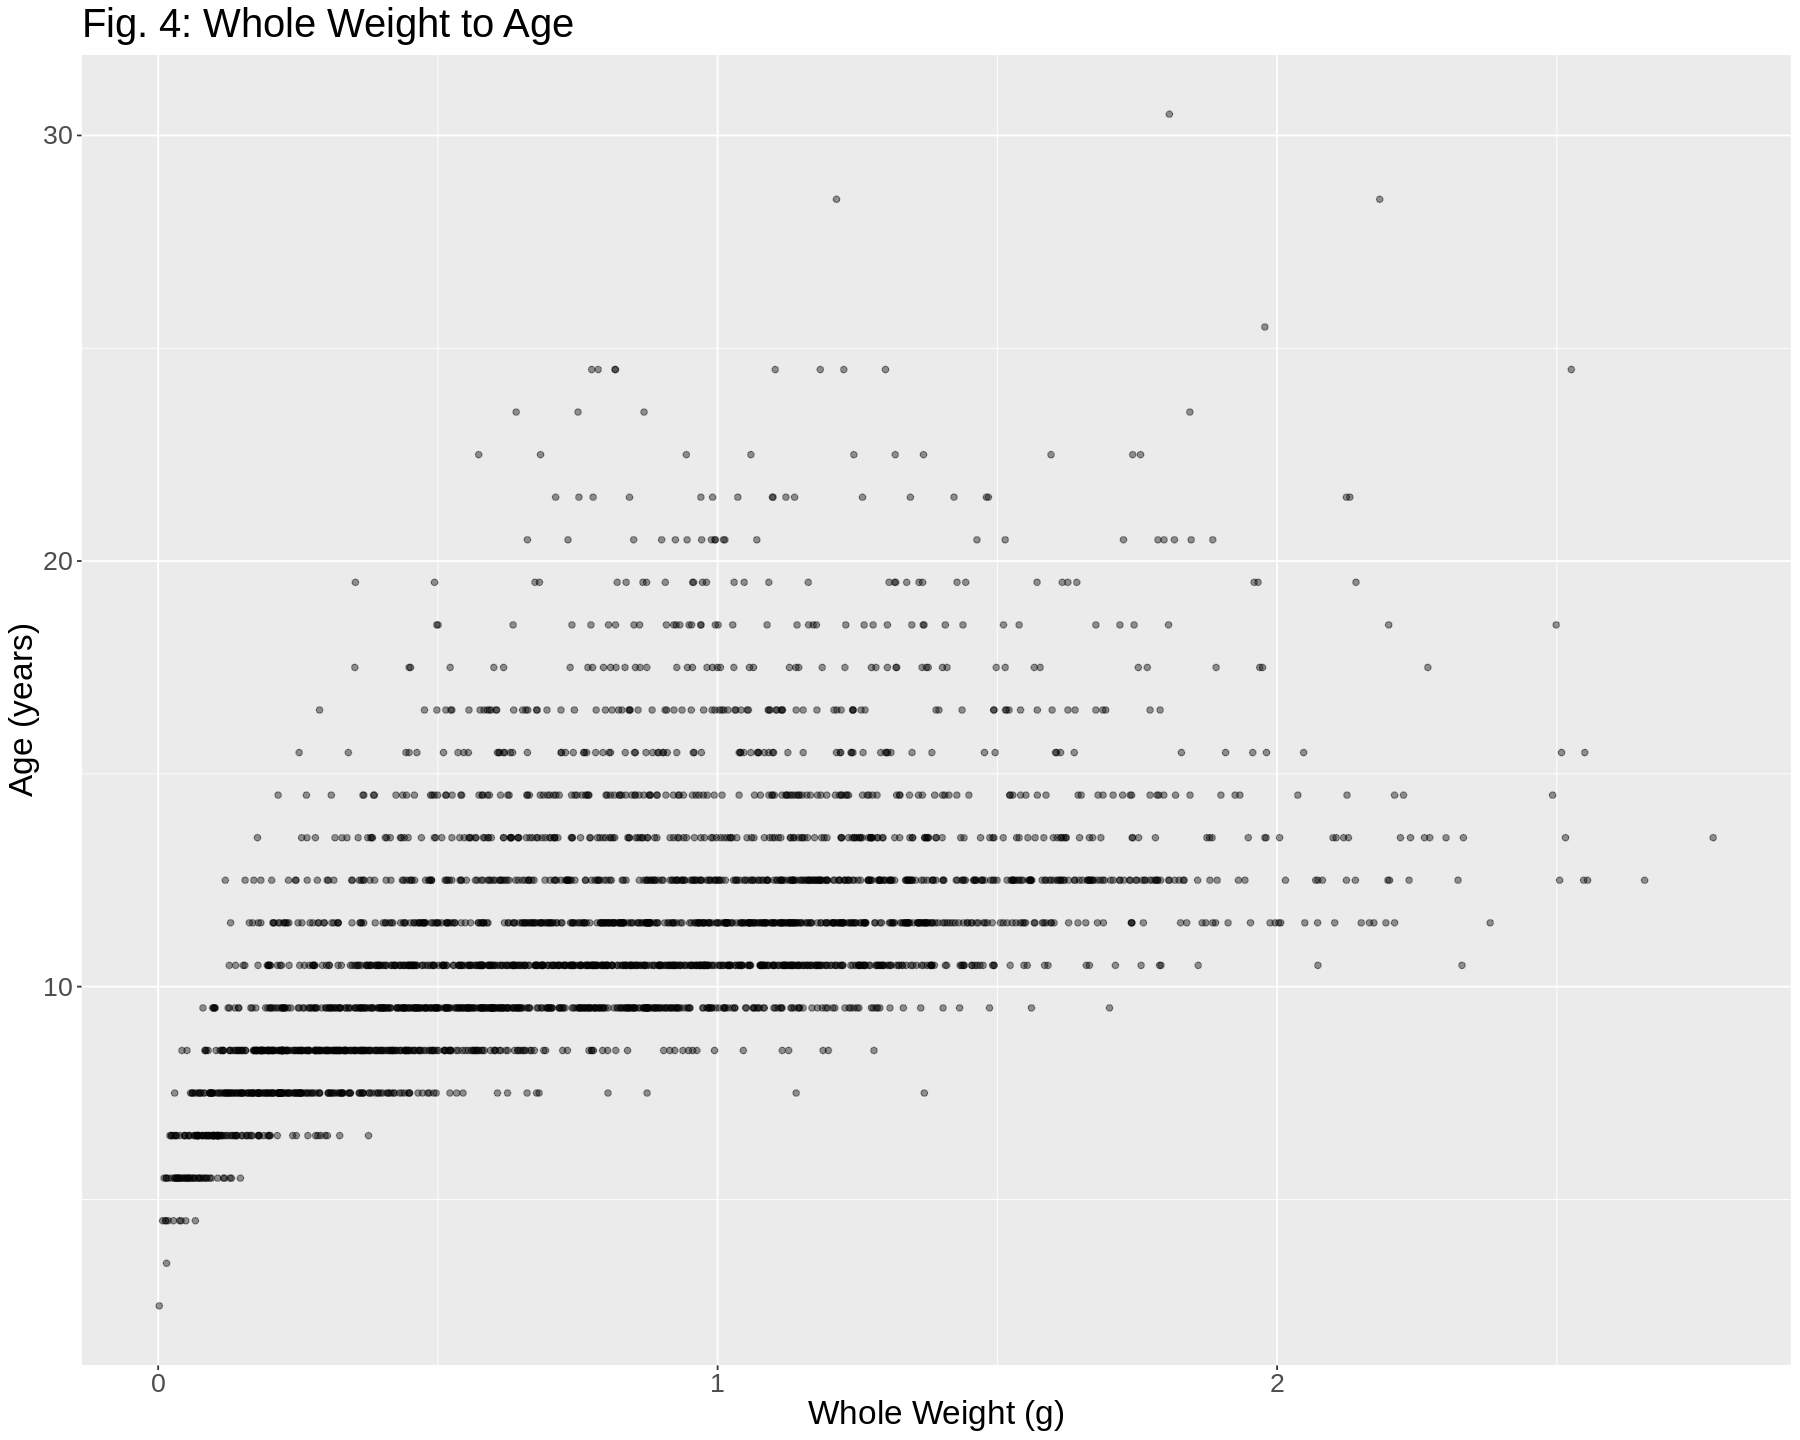

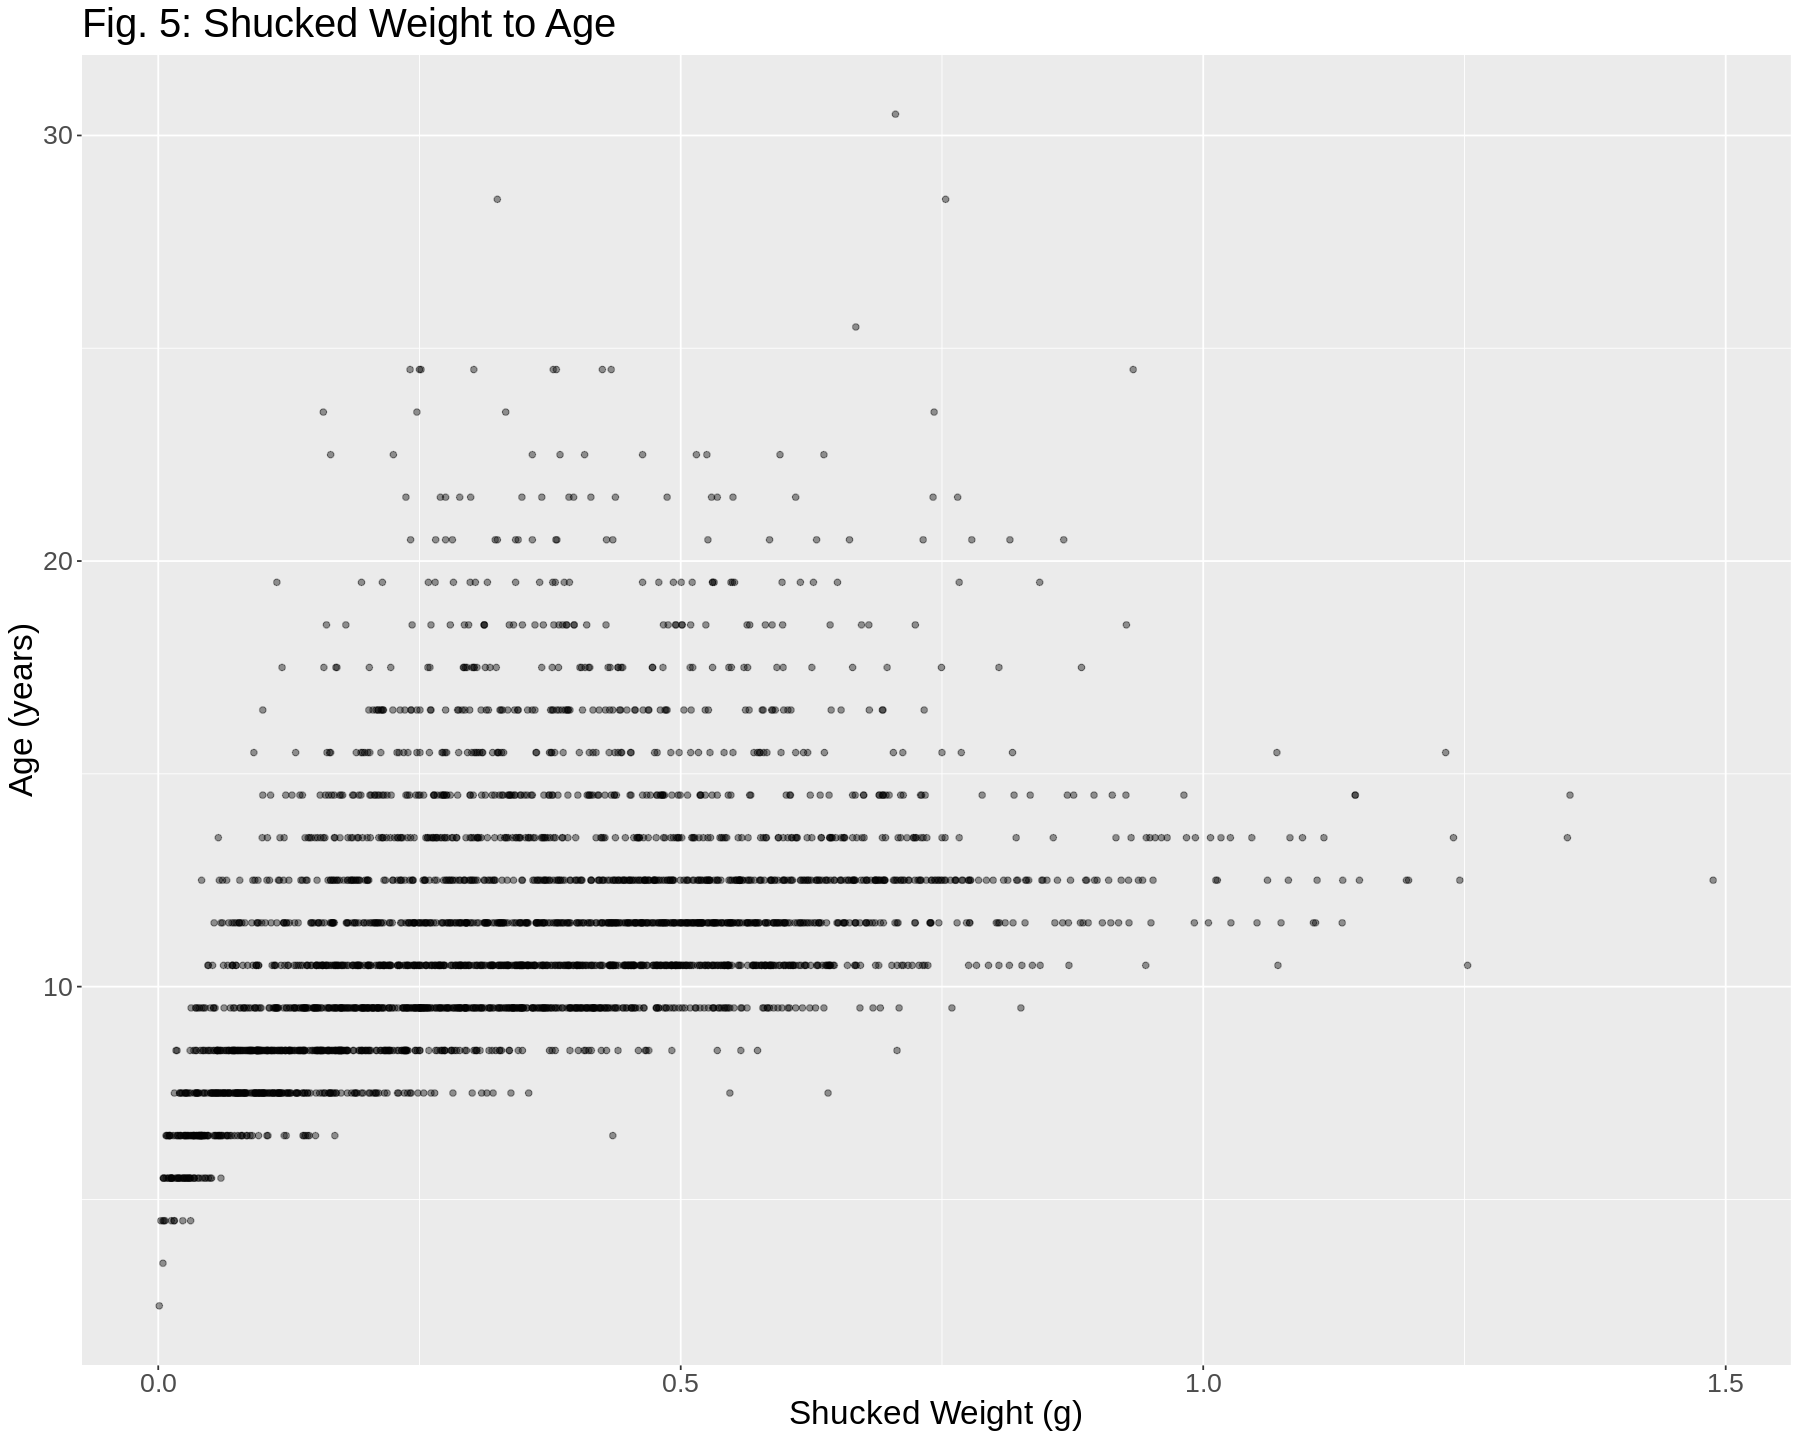

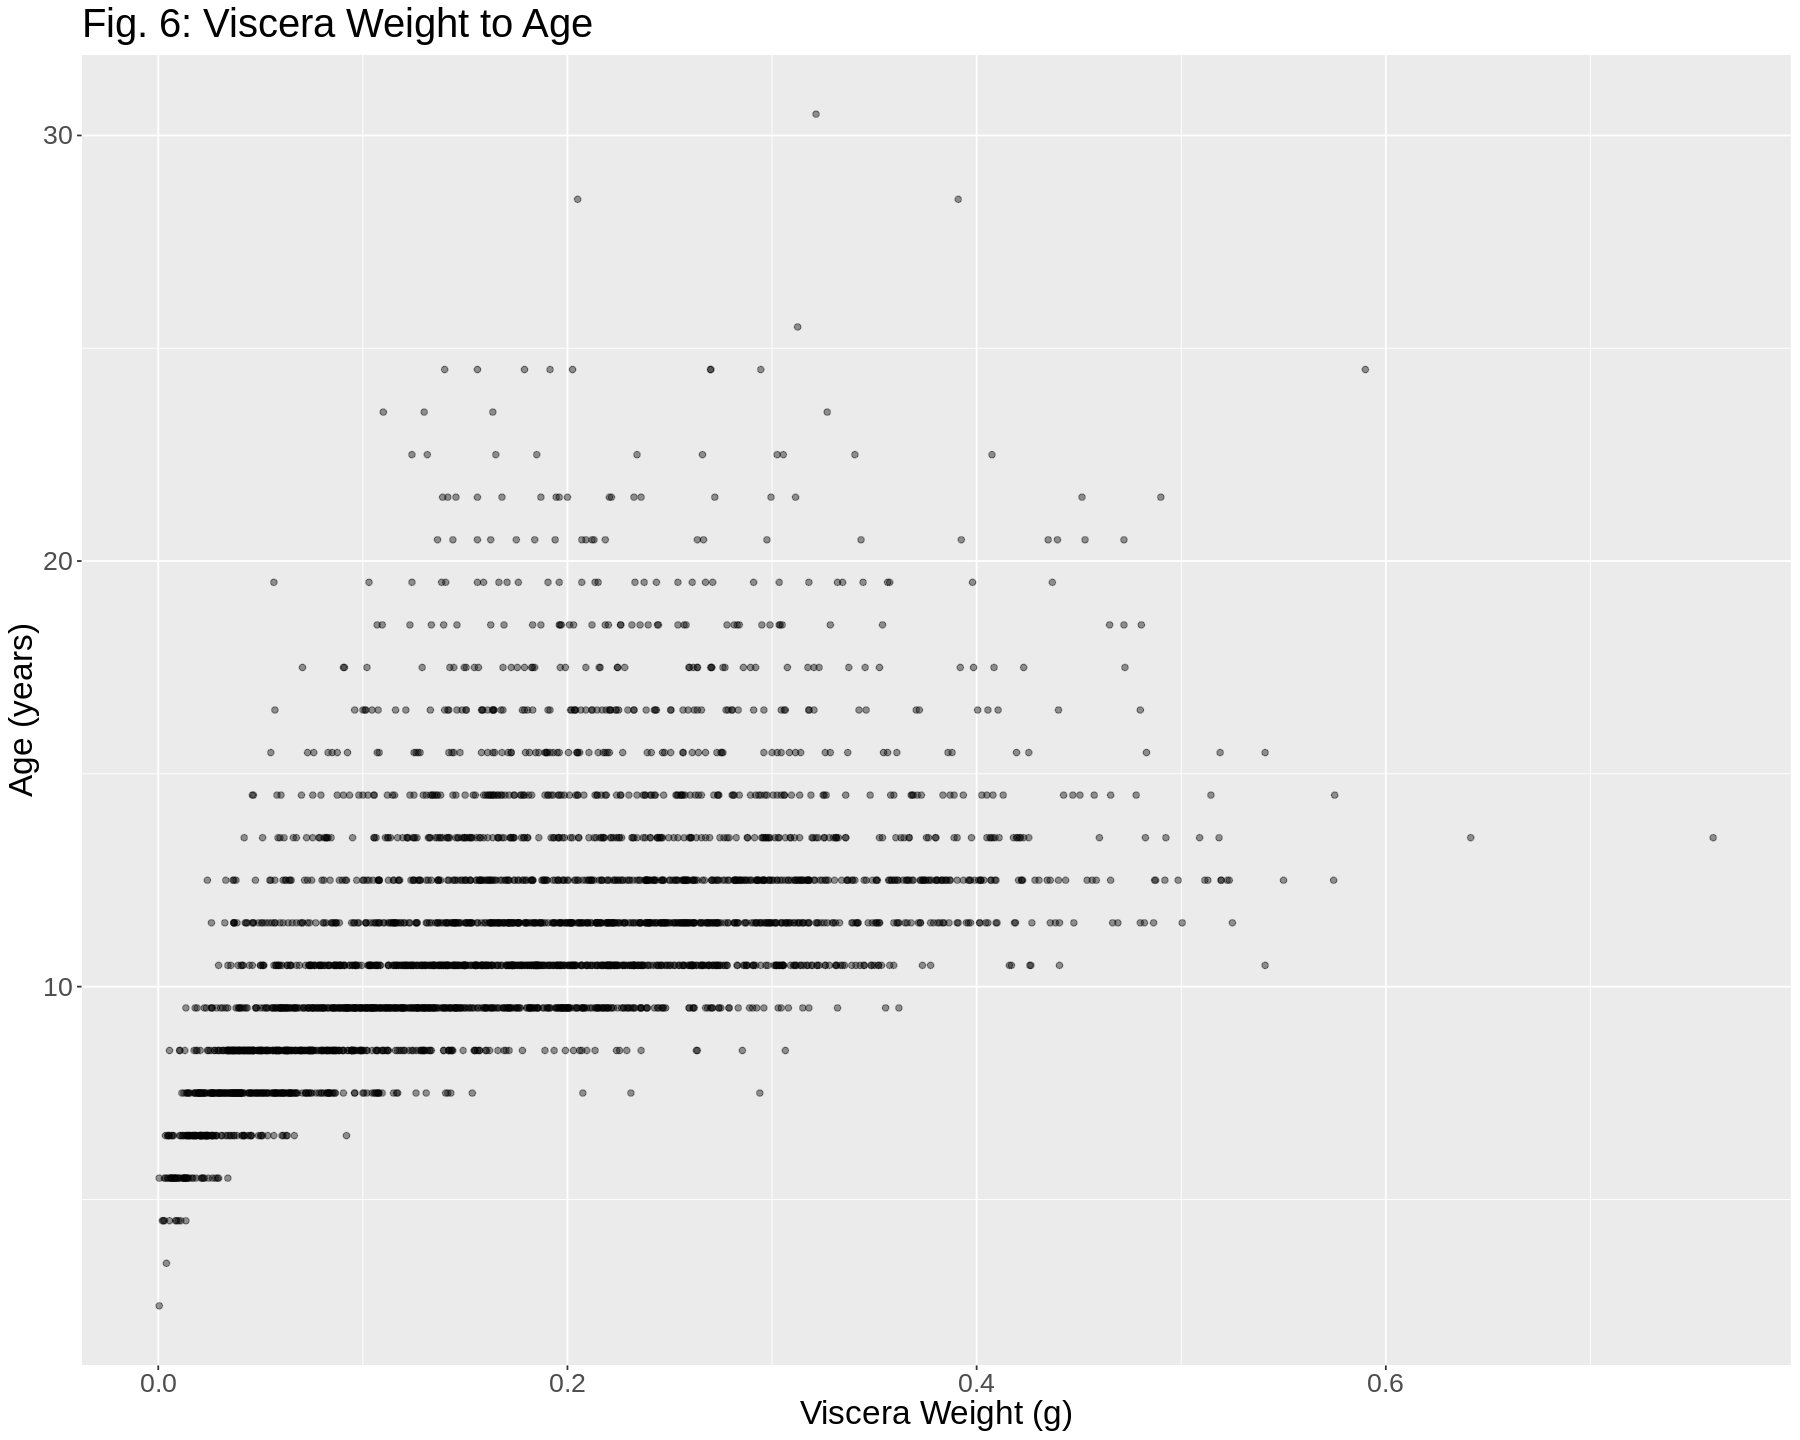

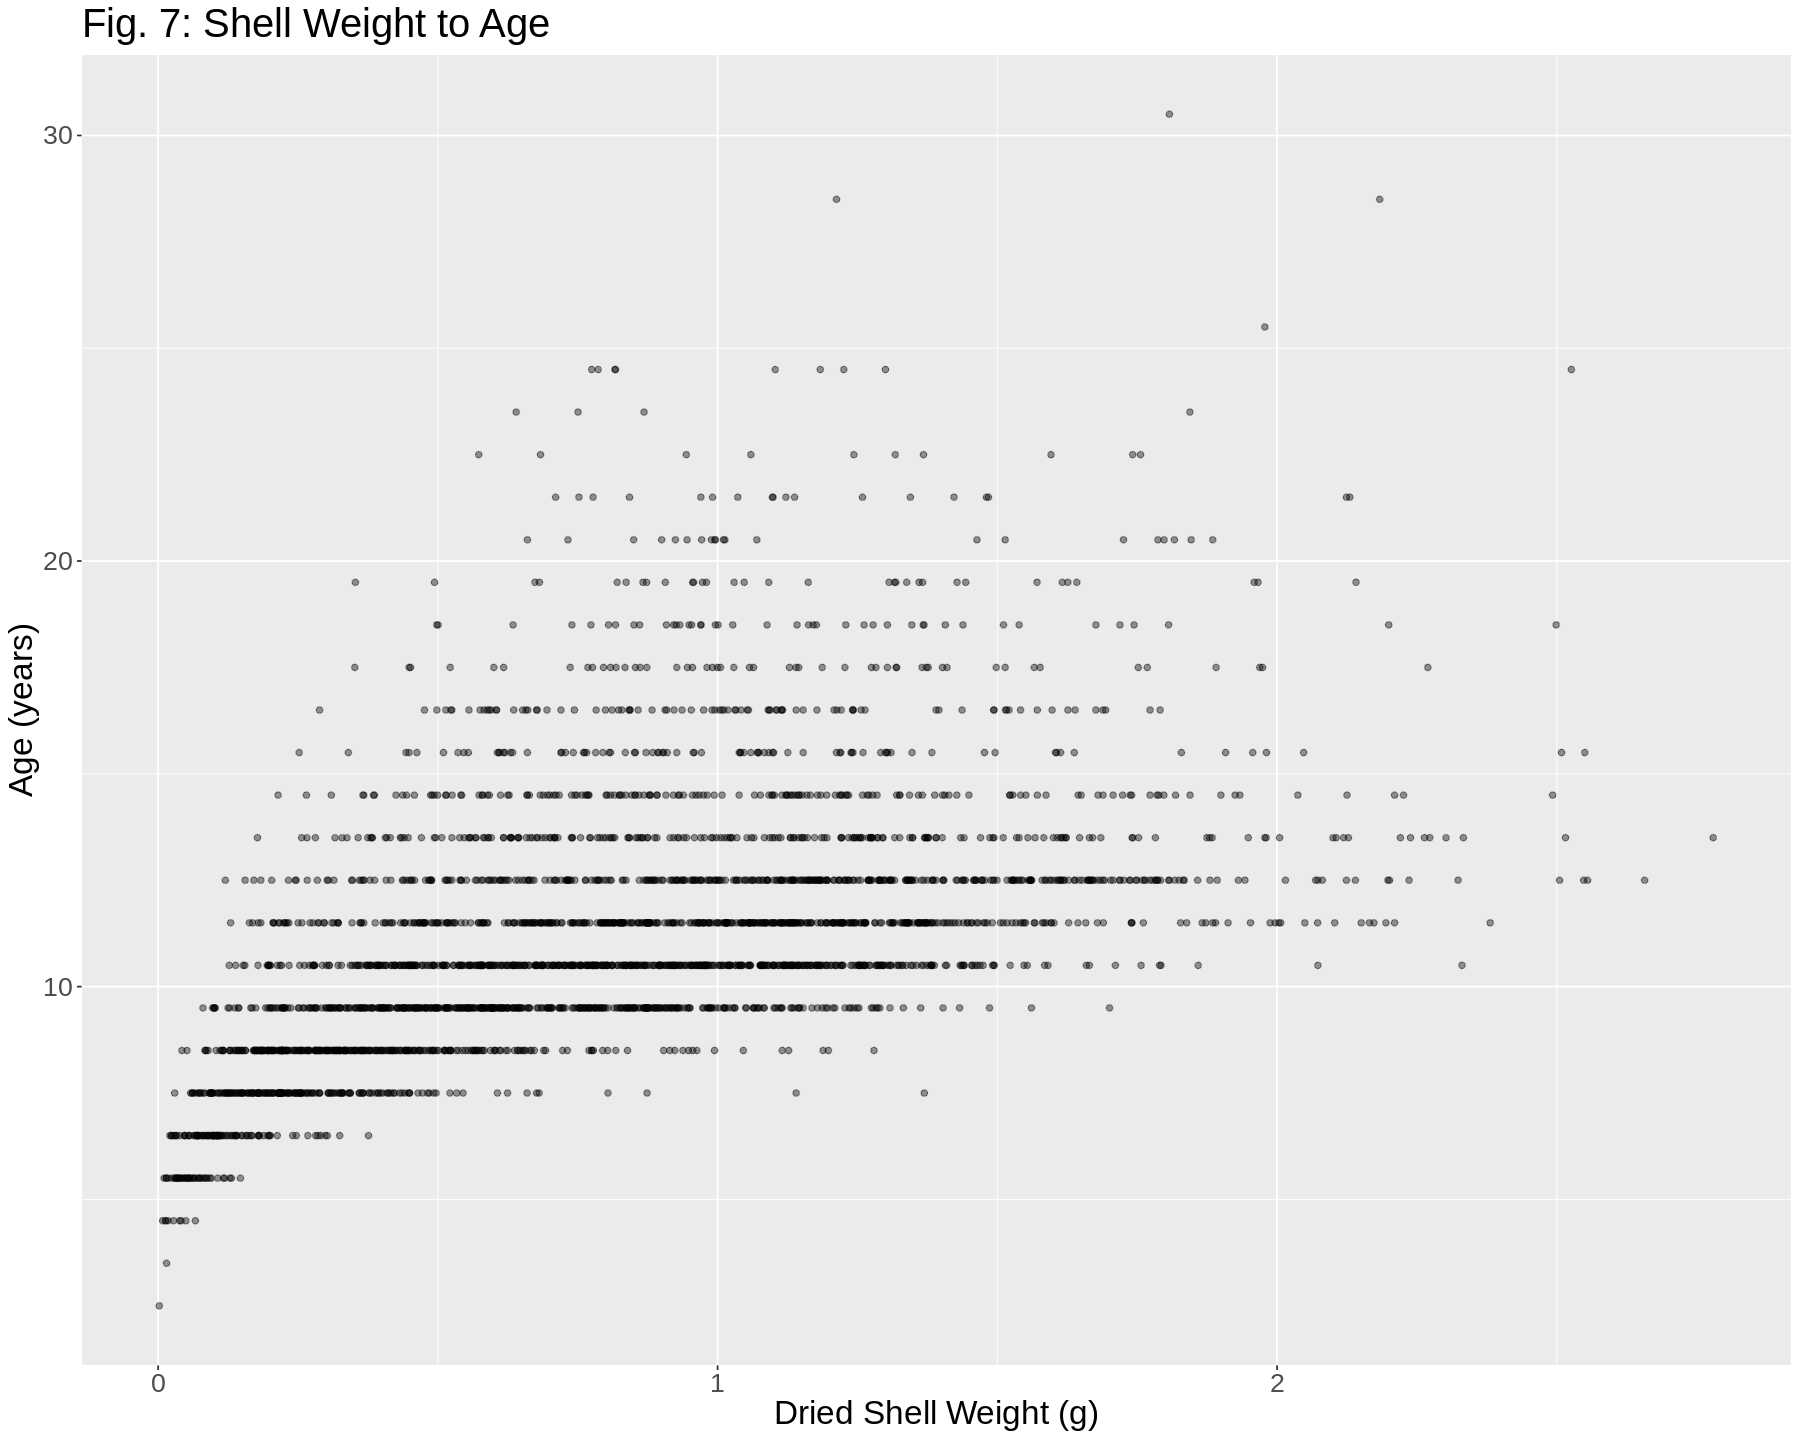

In [8]:
options(repr.plot.width = 15, repr.plot.height = 12)
age_length <- abalone_training %>%
ggplot(aes(x = length, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Longest Shell Measurement (mm)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 1: Length to Age")
age_length

age_diameter <- abalone_training %>%
ggplot(aes(x = diameter, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Length Perpendicular to Longest Shell Measurement (mm)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 2: Diameter to Age")
age_diameter

age_height <- abalone_training %>%
ggplot(aes(x = height, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Height With Meat in Shell (mm)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 3: Height to Age")
age_height

age_whole <- abalone_training %>%
ggplot(aes(x = whole_weight, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Whole Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 4: Whole Weight to Age")
age_whole

age_shucked <- abalone_training %>%
ggplot(aes(x = shucked_weight, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Shucked Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 5: Shucked Weight to Age")
age_shucked

age_viscera <- abalone_training %>%
ggplot(aes(x = viscera_weight, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Viscera Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 6: Viscera Weight to Age")
age_viscera

age_shell <- abalone_training %>%
ggplot(aes(x = whole_weight, y = age)) +
geom_point(alpha = 0.4) +
labs(x = "Dried Shell Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Fig. 7: Shell Weight to Age")
age_shell

## Methods

In the following code, we use sex, length, diameter, height, and whole weight to predict age. Since the predictors vary with the sex of the Abalone and sex is the only factor predictor, we create three separate models for each sex. Based on the visualization section, our chosen predictors have a strong relationship with the age, and weight measurements beyond whole weight are very similar and thus will be excluded, as they are more likely to make the model overvalue weight than to provide additional information.

We will use regression to predict the ages because age is a quantitative value. In classification, a prediction can only be completely true or completely false, while in regression the size of the error is measurable. This means that a model which produces slightly wrong predictions will be treated as better than a model that produces very wrong predictions, rather than as equally bad. Specifically, we will use K-nearest-neighbor regression. This is more appropriate than linear regression because the ablones' growth rates might change during their life cycles. K-nearest-neighbor models can adapt to this, but linear models cannot. They cannot extrapolate when given predictors beyond the range of the training data, but this is unlikely to occur in real world use because ablones cannot grow beyond a certain size.

Our data analysis is shown below along with descriptions of the process.

## Results
The code below performs **three separate 5-fold cross validations on the training data set, split according to sex**, in order to examine the accuracy metrics yielded by k values from 1-200. Tables of these metrics are shown below the code (male, female, then infant).

In [9]:
set.seed(1234)
abalone_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

abalone_male_recipe <- recipe(age ~ length + diameter + height + whole_weight, data = abalone_training_male) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

abalone_male_vfold <- vfold_cv(abalone_training_male, v = 5, strata = age)

abalone_male_workflow <- workflow() %>%
    add_recipe(abalone_male_recipe) %>%
    add_model(abalone_spec)

abalone_male_results <- abalone_male_workflow %>%
    tune_grid(resamples = abalone_male_vfold, grid = tibble(neighbors = seq(1,200))) %>%
    collect_metrics()
abalone_male_results

abalone_female_recipe <- recipe(age ~ length + diameter + height + whole_weight, data = abalone_training_female) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

abalone_female_vfold <- vfold_cv(abalone_training_female, v = 5, strata = age)

abalone_female_workflow <- workflow() %>%
    add_recipe(abalone_female_recipe) %>%
    add_model(abalone_spec)

abalone_female_results <- abalone_female_workflow %>%
    tune_grid(resamples = abalone_female_vfold, grid = tibble(neighbors = seq(1,200))) %>%
    collect_metrics()
abalone_female_results

abalone_infant_recipe <- recipe(age ~ length + diameter + height + whole_weight, data = abalone_training_infant) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

abalone_infant_vfold <- vfold_cv(abalone_training_infant, v = 5, strata = age)

abalone_infant_workflow <- workflow() %>%
    add_recipe(abalone_infant_recipe) %>%
    add_model(abalone_spec)

abalone_infant_results <- abalone_infant_workflow %>%
    tune_grid(resamples = abalone_infant_vfold, grid = tibble(neighbors = seq(1,200))) %>%
    collect_metrics()
abalone_infant_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,3.68435124,5,0.05884325,Model001
1,rsq,standard,0.05356091,5,0.01329297,Model001
2,rmse,standard,3.11339174,5,0.07434919,Model002
2,rsq,standard,0.10748025,5,0.01500476,Model002
3,rmse,standard,2.91204314,5,0.08510683,Model003
3,rsq,standard,0.14730817,5,0.01584274,Model003
4,rmse,standard,2.81153768,5,0.08682706,Model004
4,rsq,standard,0.17200136,5,0.02062570,Model004
5,rmse,standard,2.77758194,5,0.08824525,Model005


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,4.054729956,5,0.134327186,Model001
1,rsq,standard,0.005512908,5,0.002141594,Model001
2,rmse,standard,3.734255347,5,0.129338266,Model002
2,rsq,standard,0.008590814,5,0.003612633,Model002
3,rmse,standard,3.507092858,5,0.132402570,Model003
3,rsq,standard,0.014723734,5,0.003838245,Model003
4,rmse,standard,3.323117986,5,0.150448069,Model004
4,rsq,standard,0.028127664,5,0.007102927,Model004
5,rmse,standard,3.215387985,5,0.144554863,Model005


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.2526409,5,0.11025692,Model001
1,rsq,standard,0.3522762,5,0.04133889,Model001
2,rmse,standard,1.9774548,5,0.09140162,Model002
2,rsq,standard,0.4282058,5,0.04499265,Model002
3,rmse,standard,1.8791936,5,0.09752895,Model003
3,rsq,standard,0.4613830,5,0.04511120,Model003
4,rmse,standard,1.8629600,5,0.10816890,Model004
4,rsq,standard,0.4653498,5,0.05028828,Model004
5,rmse,standard,1.8340996,5,0.08050588,Model005


**We then arrange the tables to list the root mean square error in ascending order and take the first row to find the K value with the minimum RMSE.**

In [12]:
abalone_male_min <- abalone_male_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)
abalone_male_min 

abalone_female_min <- abalone_female_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)
abalone_female_min

abalone_infant_min <- abalone_infant_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)
abalone_infant_min 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,2.634508,5,0.1149551,Model029


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,rmse,standard,2.92757,5,0.1498505,Model073


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,rmse,standard,1.736715,5,0.0722622,Model021


**Our three regression models are then recreated with the chosen K values. Next, we fit these models onto the testing data sets to make predictions and examine the accuracy results for each sex.**

In [14]:
set.seed(1234)
k_male_min <- abalone_male_min %>%
    pull(neighbors)

abalone_male_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_male_min) %>%
    set_engine("kknn") %>%
    set_mode("regression")

abalone_male_best_fit <- workflow() %>%
    add_recipe(abalone_male_recipe) %>%
    add_model(abalone_male_best_spec) %>%
    fit(data = abalone_training_male)

abalone_male_summary <- abalone_male_best_fit %>%
    predict(abalone_testing_male) %>%
    bind_cols(abalone_testing_male) %>%
    metrics(truth = age, estimate = .pred)
abalone_male_summary

k_female_min <- abalone_female_min %>%
    pull(neighbors)

abalone_female_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_female_min) %>%
    set_engine("kknn") %>%
    set_mode("regression")

abalone_female_best_fit <- workflow() %>%
    add_recipe(abalone_female_recipe) %>%
    add_model(abalone_female_best_spec) %>%
    fit(data = abalone_training_female)

abalone_female_summary <- abalone_female_best_fit %>%
    predict(abalone_testing_female) %>%
    bind_cols(abalone_testing_female) %>%
    metrics(truth = age, estimate = .pred)
abalone_female_summary

k_infant_min <- abalone_infant_min %>%
    pull(neighbors)

abalone_infant_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_infant_min) %>%
    set_engine("kknn") %>%
    set_mode("regression")

abalone_infant_best_fit <- workflow() %>%
    add_recipe(abalone_infant_recipe) %>%
    add_model(abalone_infant_best_spec) %>%
    fit(data = abalone_training_infant)

abalone_infant_summary <- abalone_infant_best_fit %>%
    predict(abalone_testing_infant) %>%
    bind_cols(abalone_testing_infant) %>%
    metrics(truth = age, estimate = .pred)
abalone_infant_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.7516865
rsq,standard,0.2231472
mae,standard,1.9792196


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.8184456
rsq,standard,0.1670781
mae,standard,2.0913942


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.7185872
rsq,standard,0.5333637
mae,standard,1.1392928


**All subsequent code serves to visualize the fit of the model onto the training data sets**

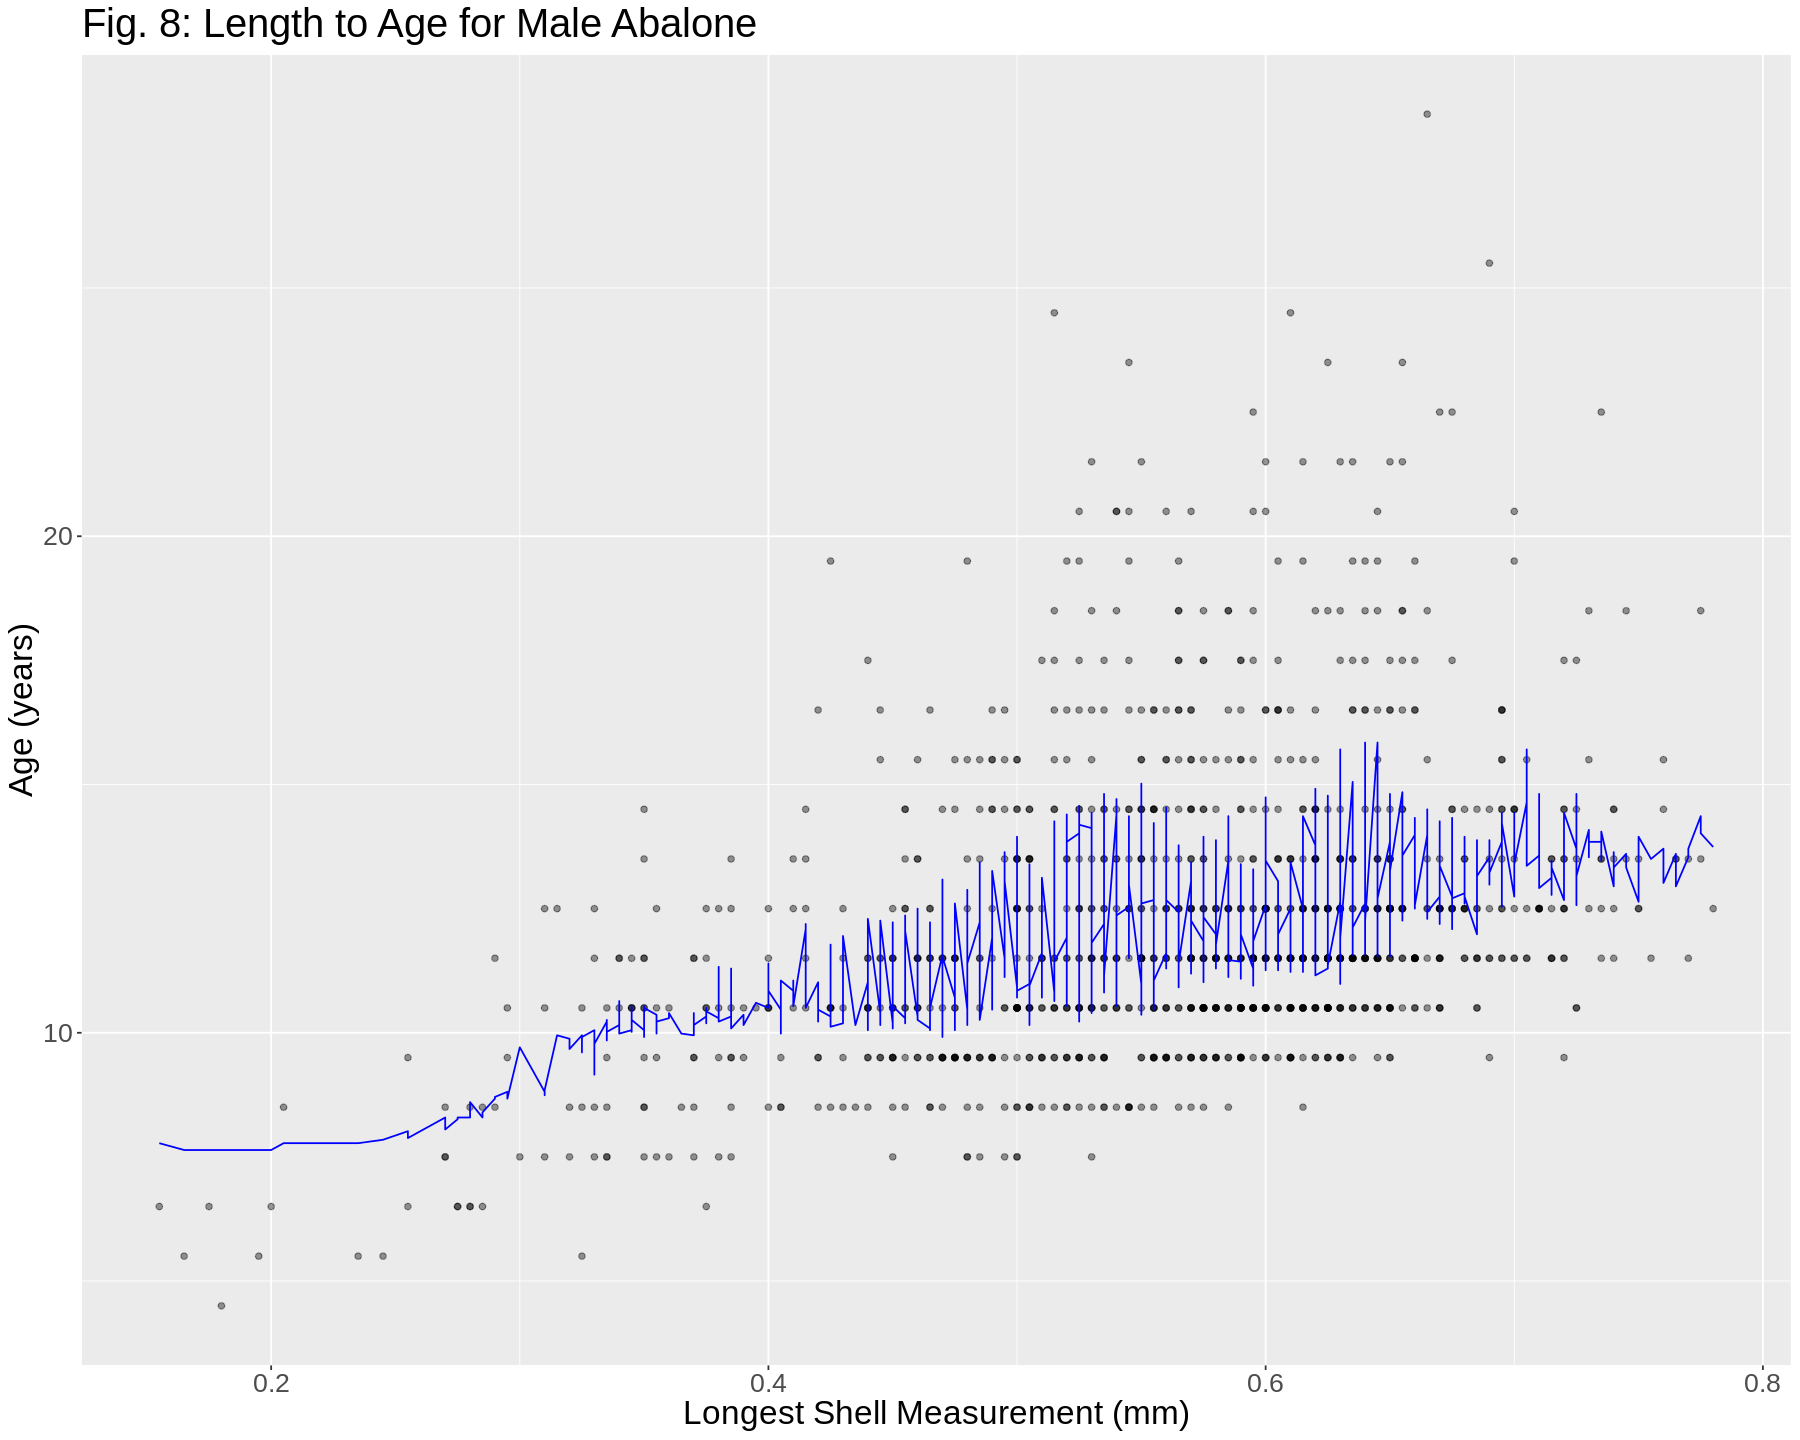

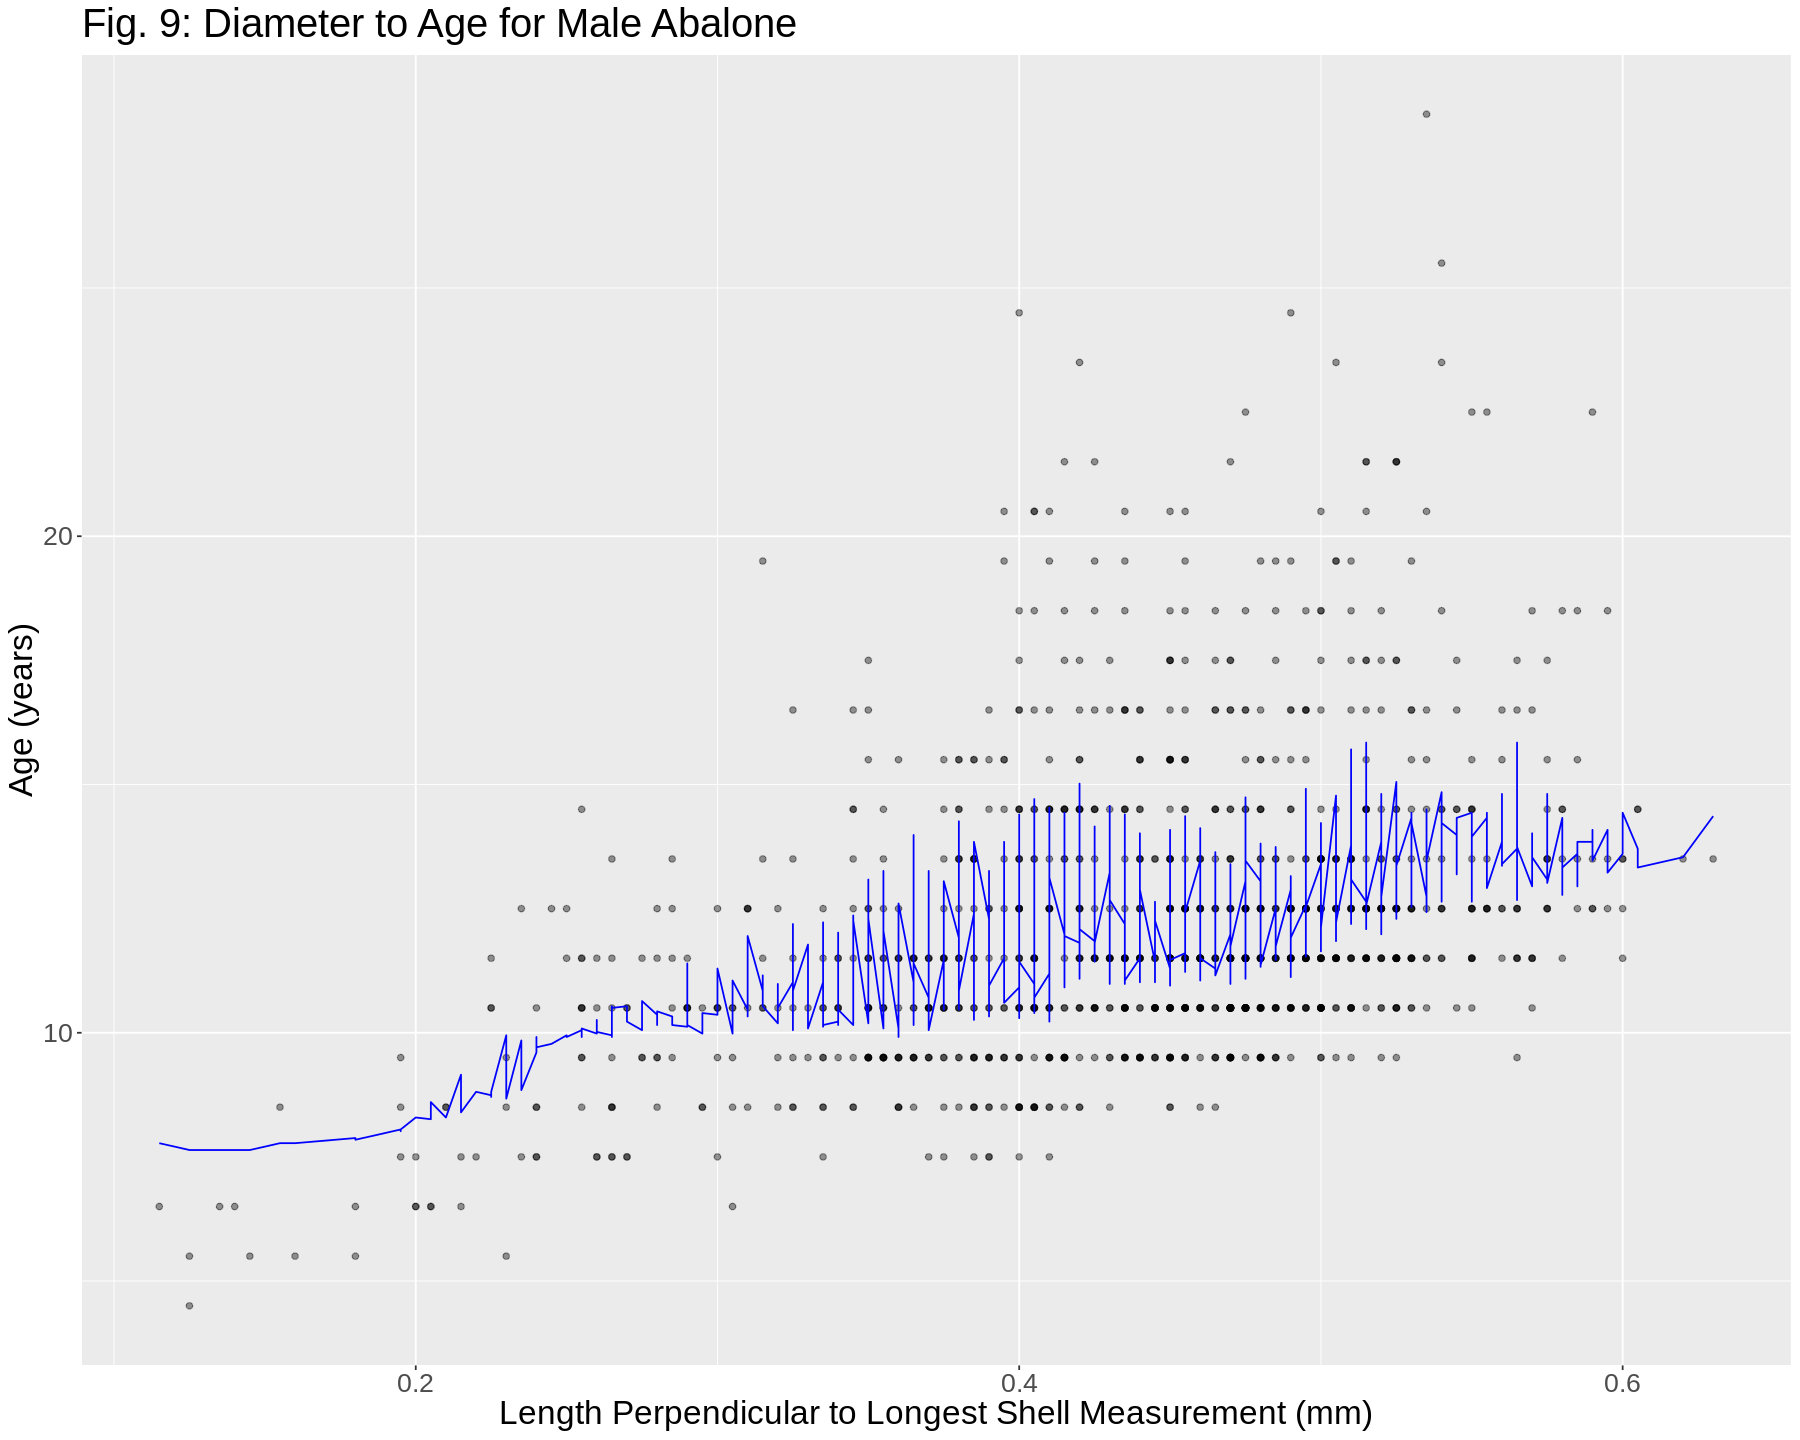

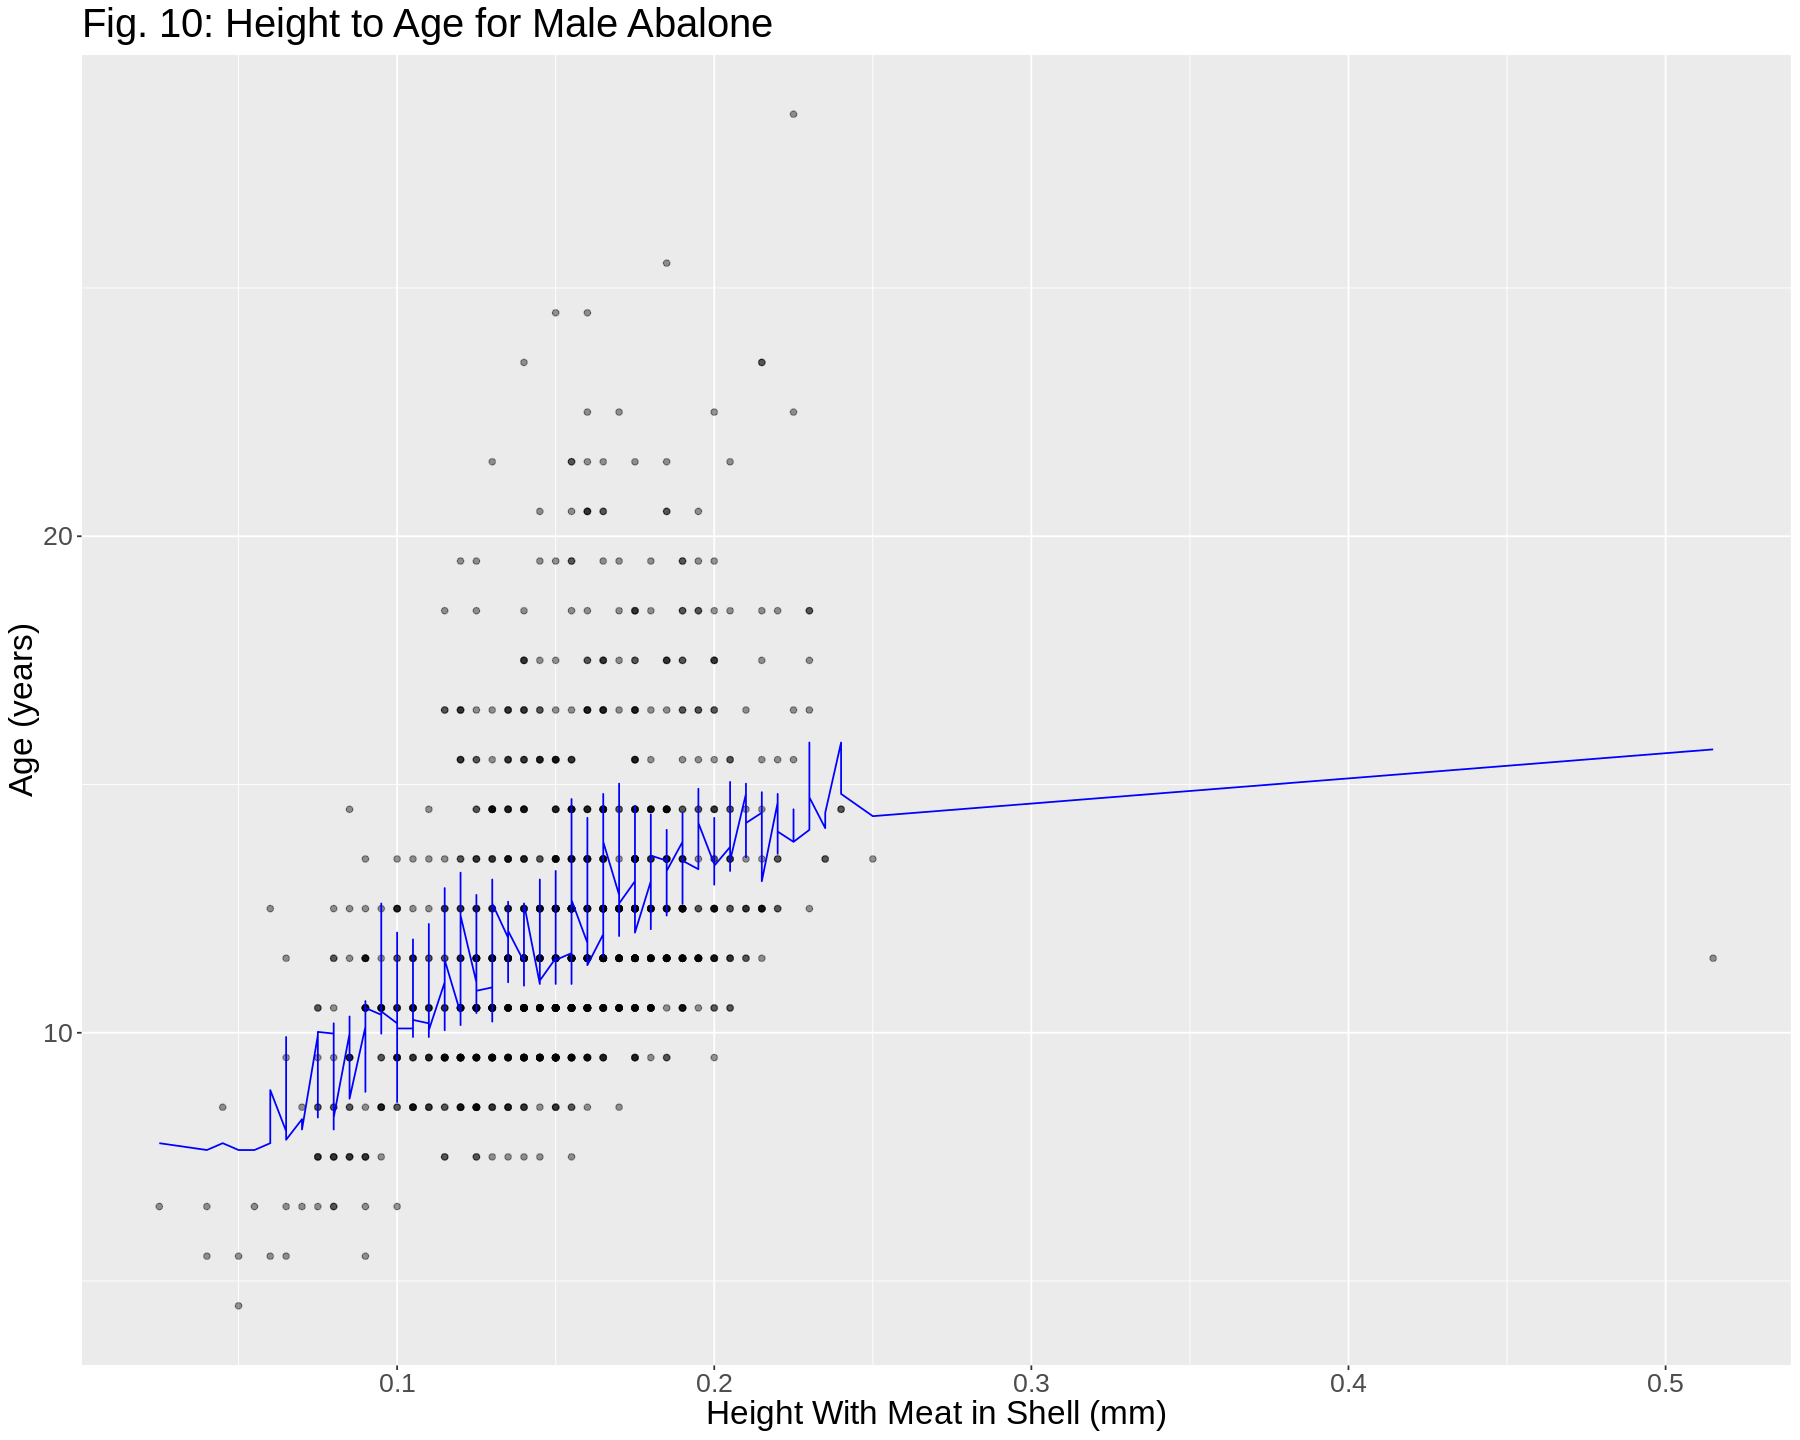

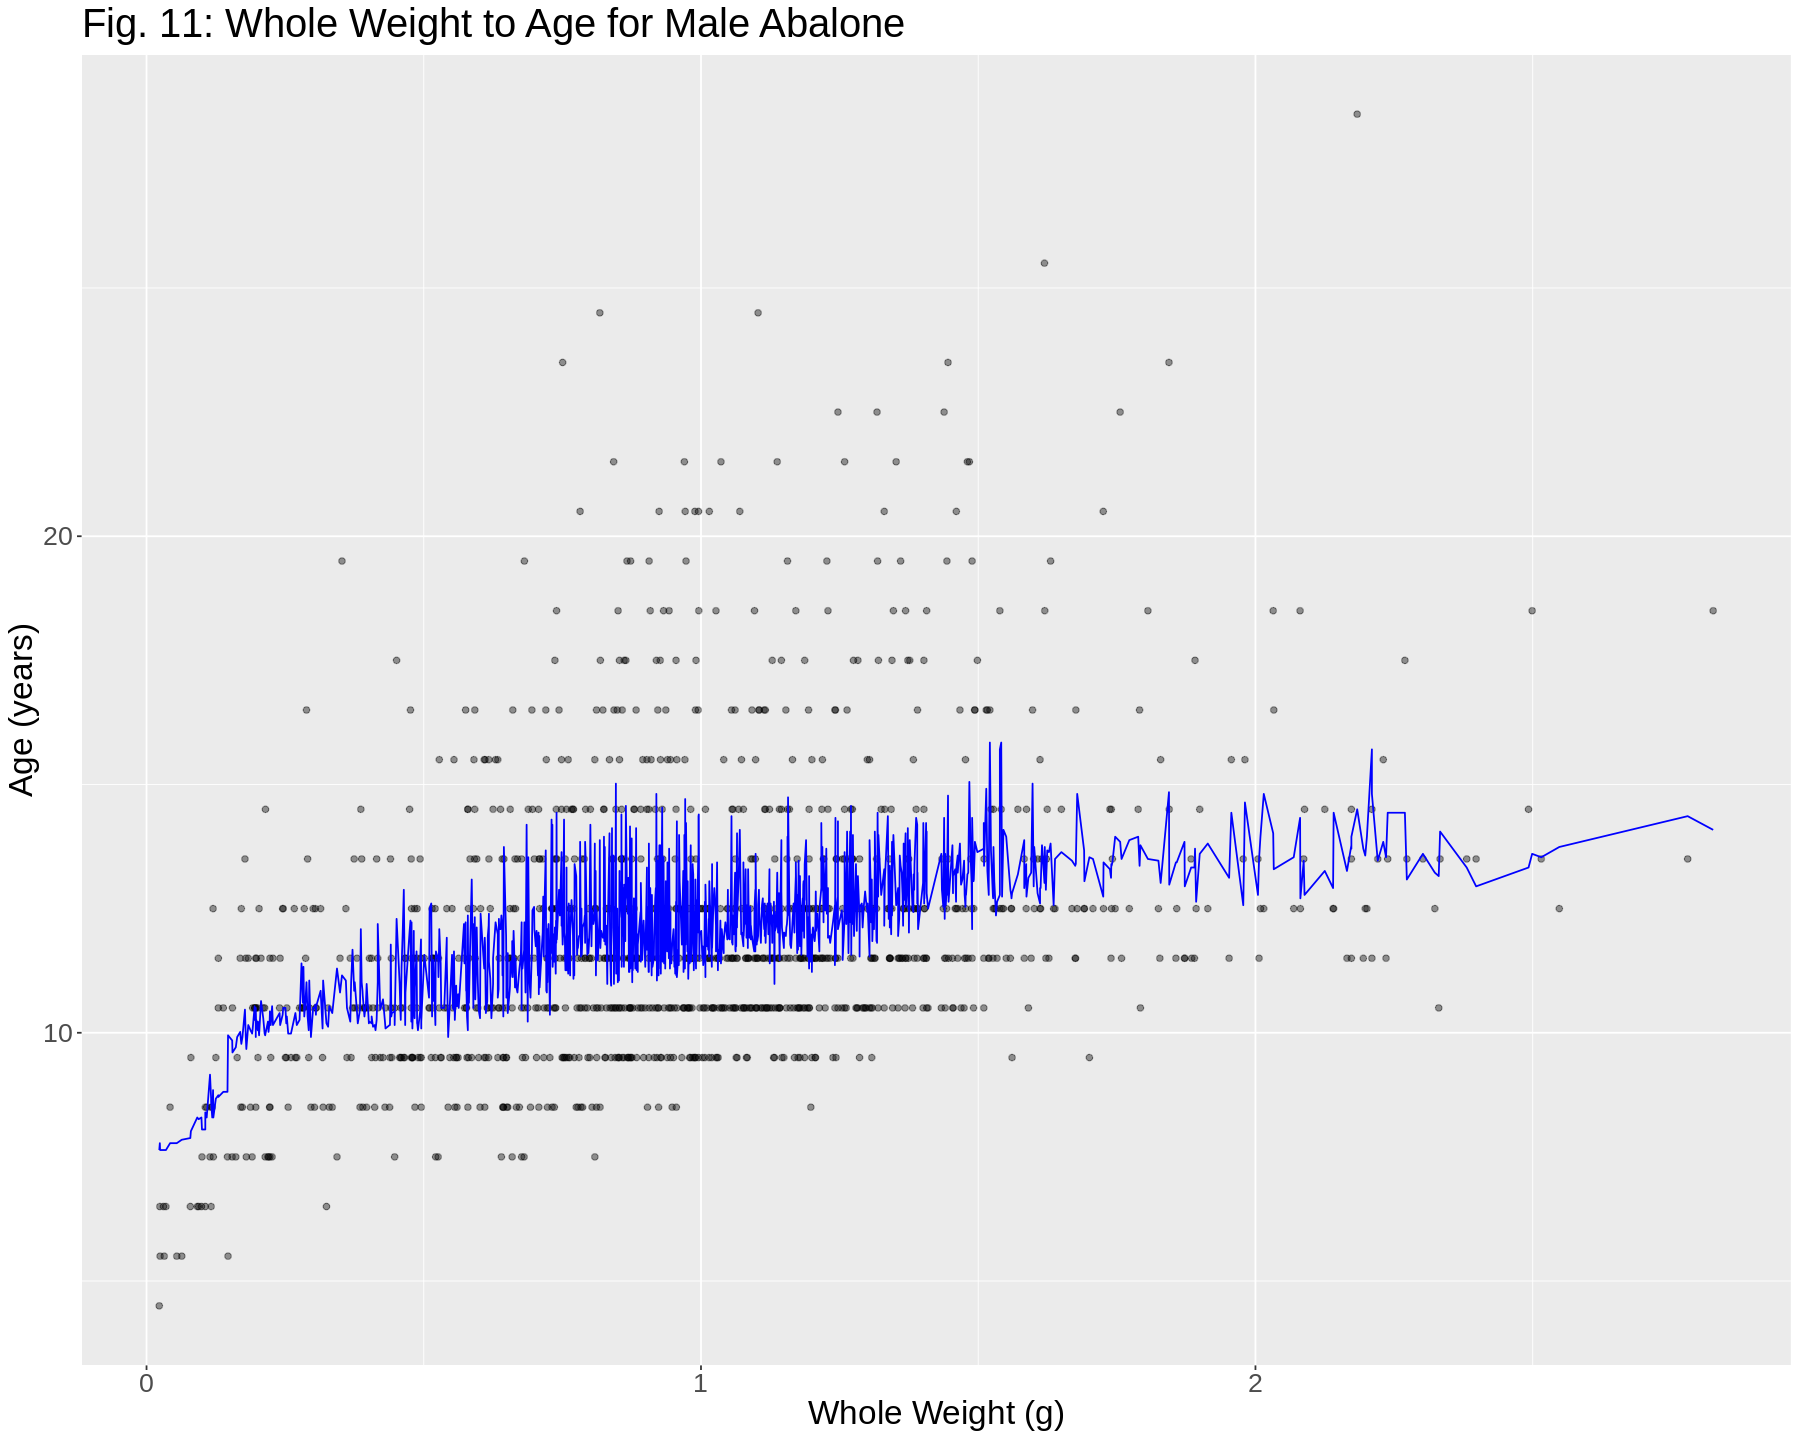

In [16]:
abalone_male_preds <- abalone_male_best_fit %>%
    predict(abalone_training_male) %>%
    bind_cols(abalone_training_male)

abalone_male_length_plot <- abalone_male_preds %>%
    ggplot(aes(x = length, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = length, y = .pred), color = "blue") +
    labs(x = "Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 8: Length to Age for Male Abalone") +
    theme(text = element_text(size=20))
abalone_male_length_plot

abalone_male_diameter_plot <- abalone_male_preds %>%
    ggplot(aes(x = diameter, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = diameter, y = .pred), color = "blue") +
    labs(x = "Length Perpendicular to Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 9: Diameter to Age for Male Abalone") +
    theme(text = element_text(size=20))
abalone_male_diameter_plot

abalone_male_height_plot <- abalone_male_preds %>%
    ggplot(aes(x = height, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = height, y = .pred), color = "blue") +
    labs(x = "Height With Meat in Shell (mm)", y = "Age (years)") +
    ggtitle("Fig. 10: Height to Age for Male Abalone") +
    theme(text = element_text(size=20))
abalone_male_height_plot

abalone_male_whole_plot <- abalone_male_preds %>%
    ggplot(aes(x = whole_weight, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = whole_weight, y = .pred), color = "blue") +
    labs(x = "Whole Weight (g)", y = "Age (years)") +
    ggtitle("Fig. 11: Whole Weight to Age for Male Abalone") +
    theme(text = element_text(size=20))
abalone_male_whole_plot


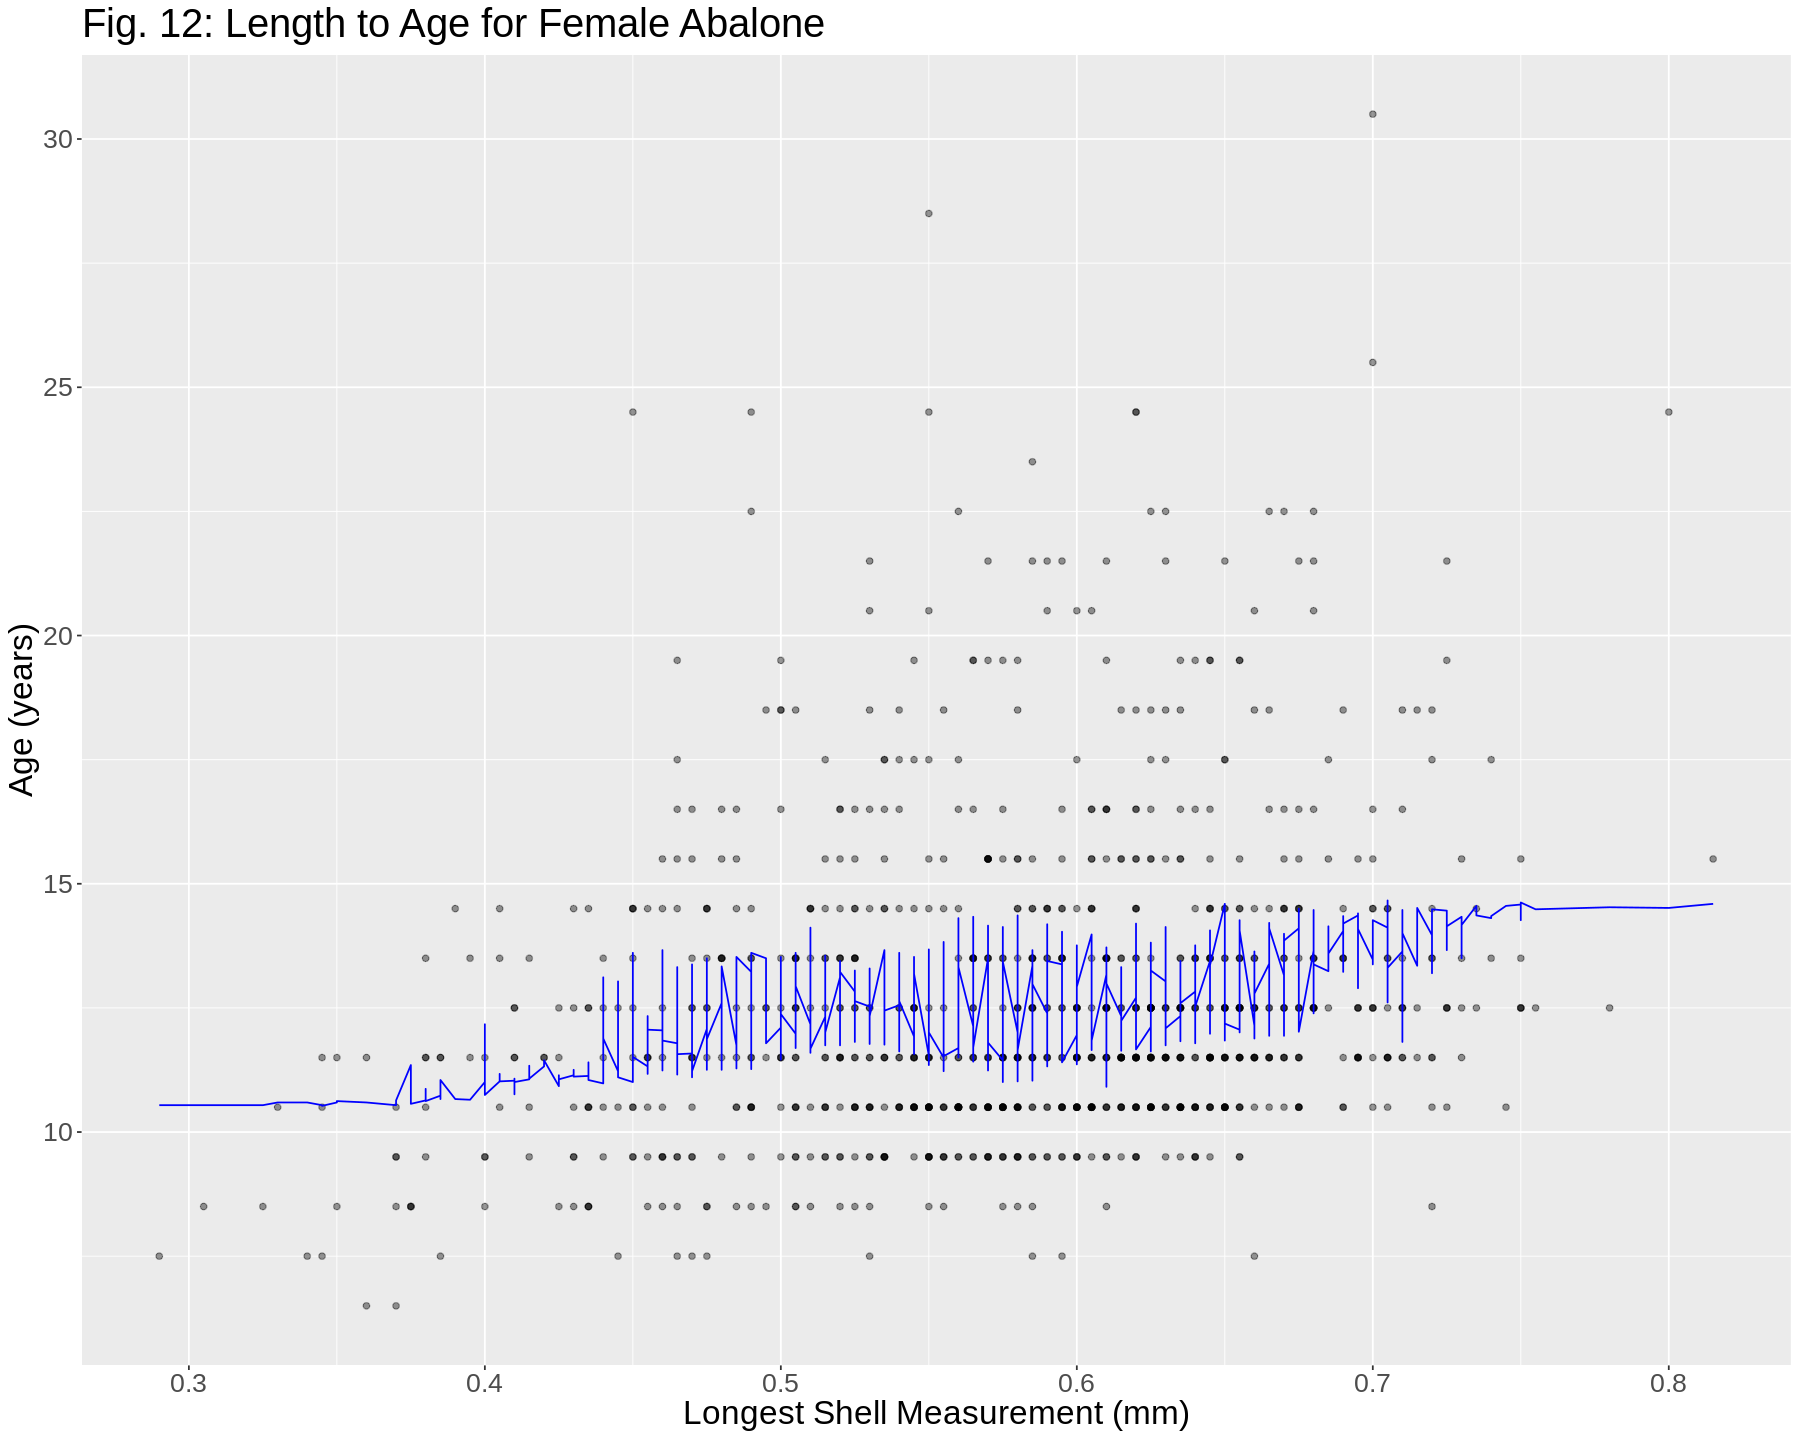

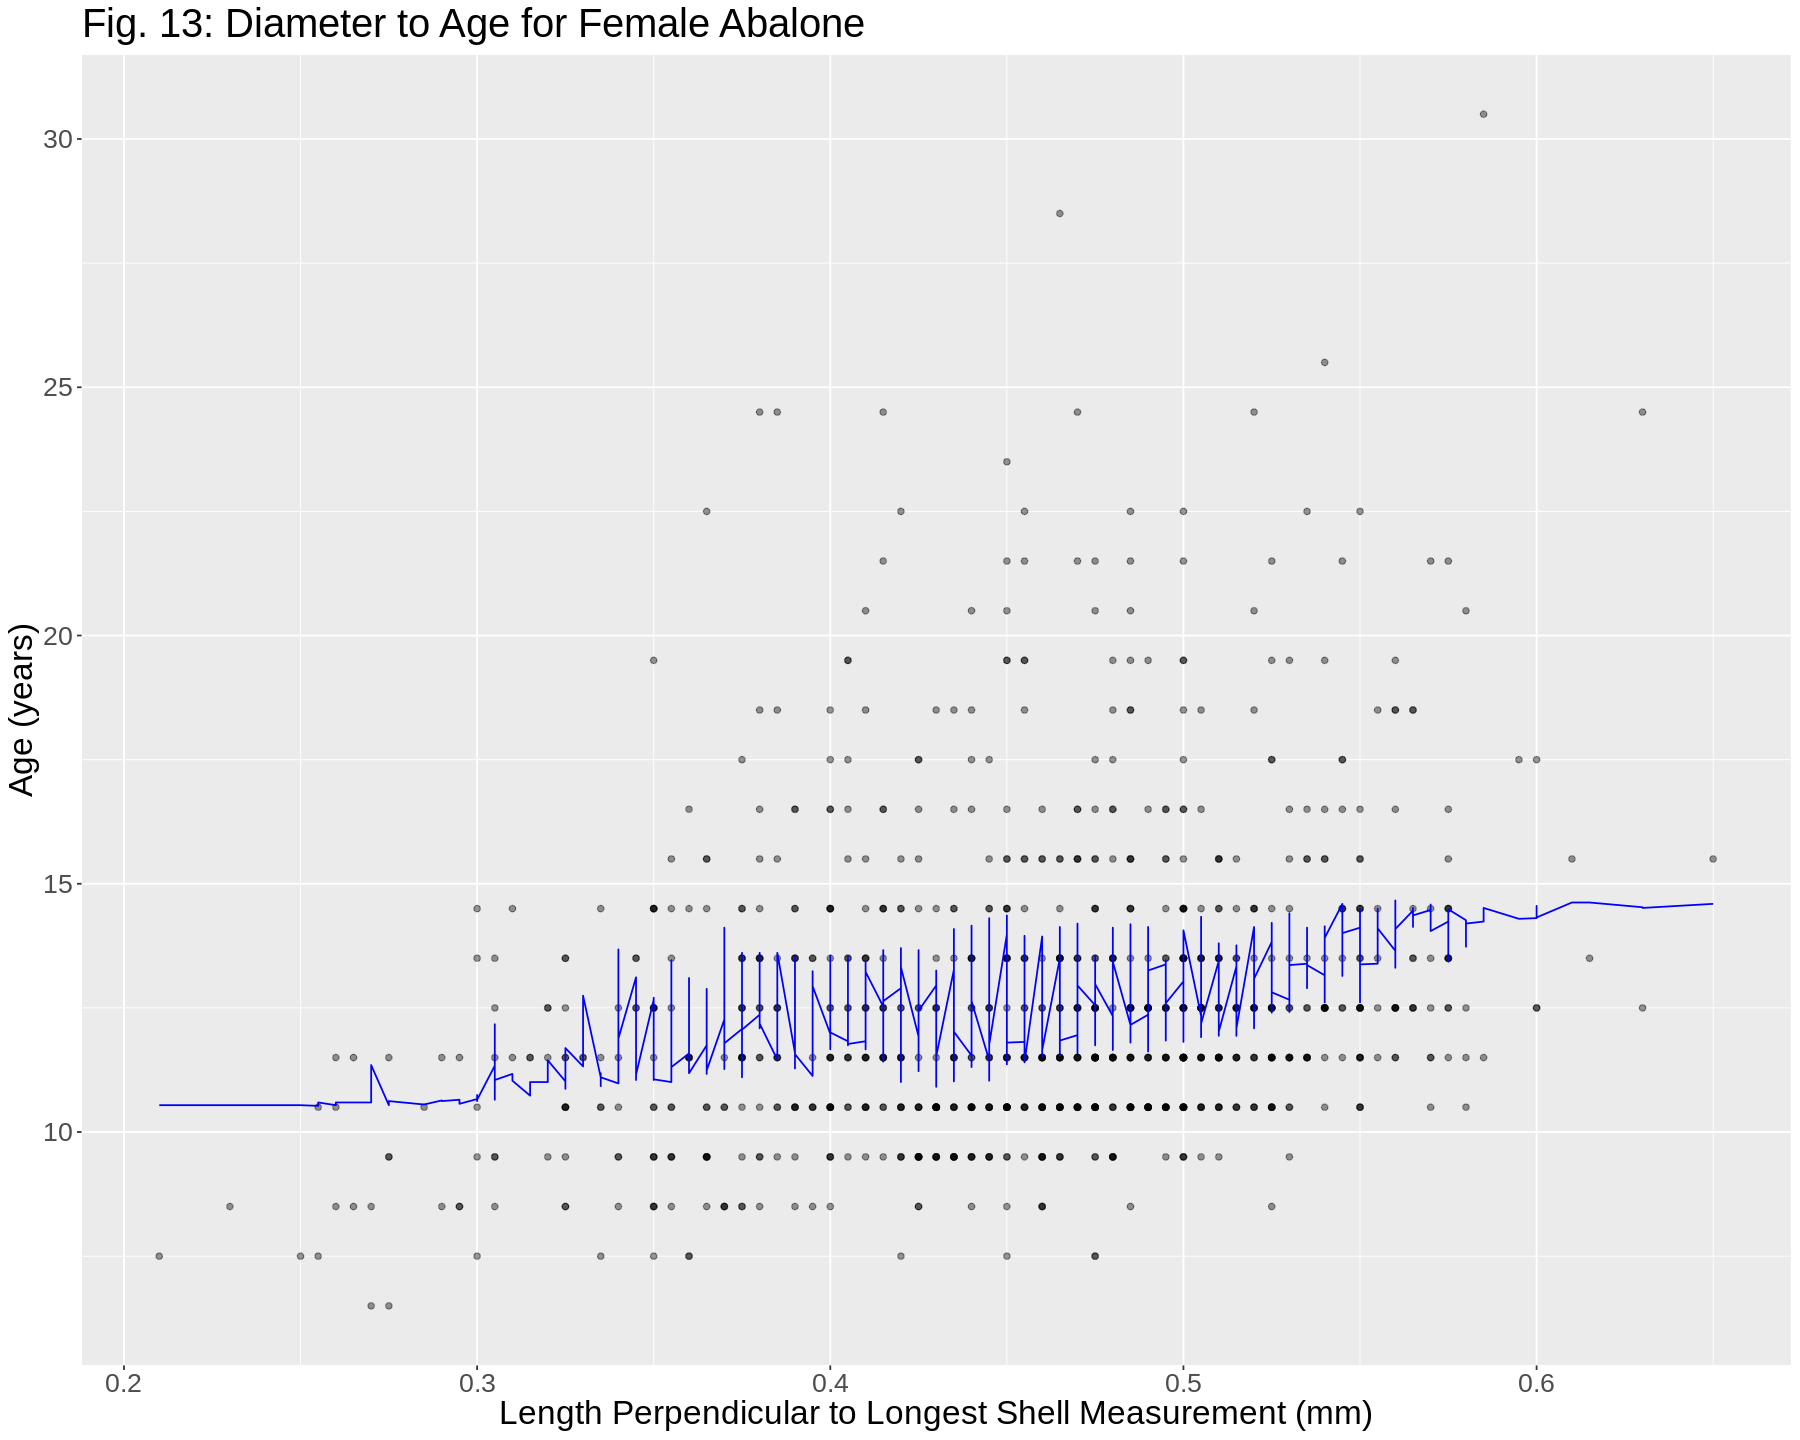

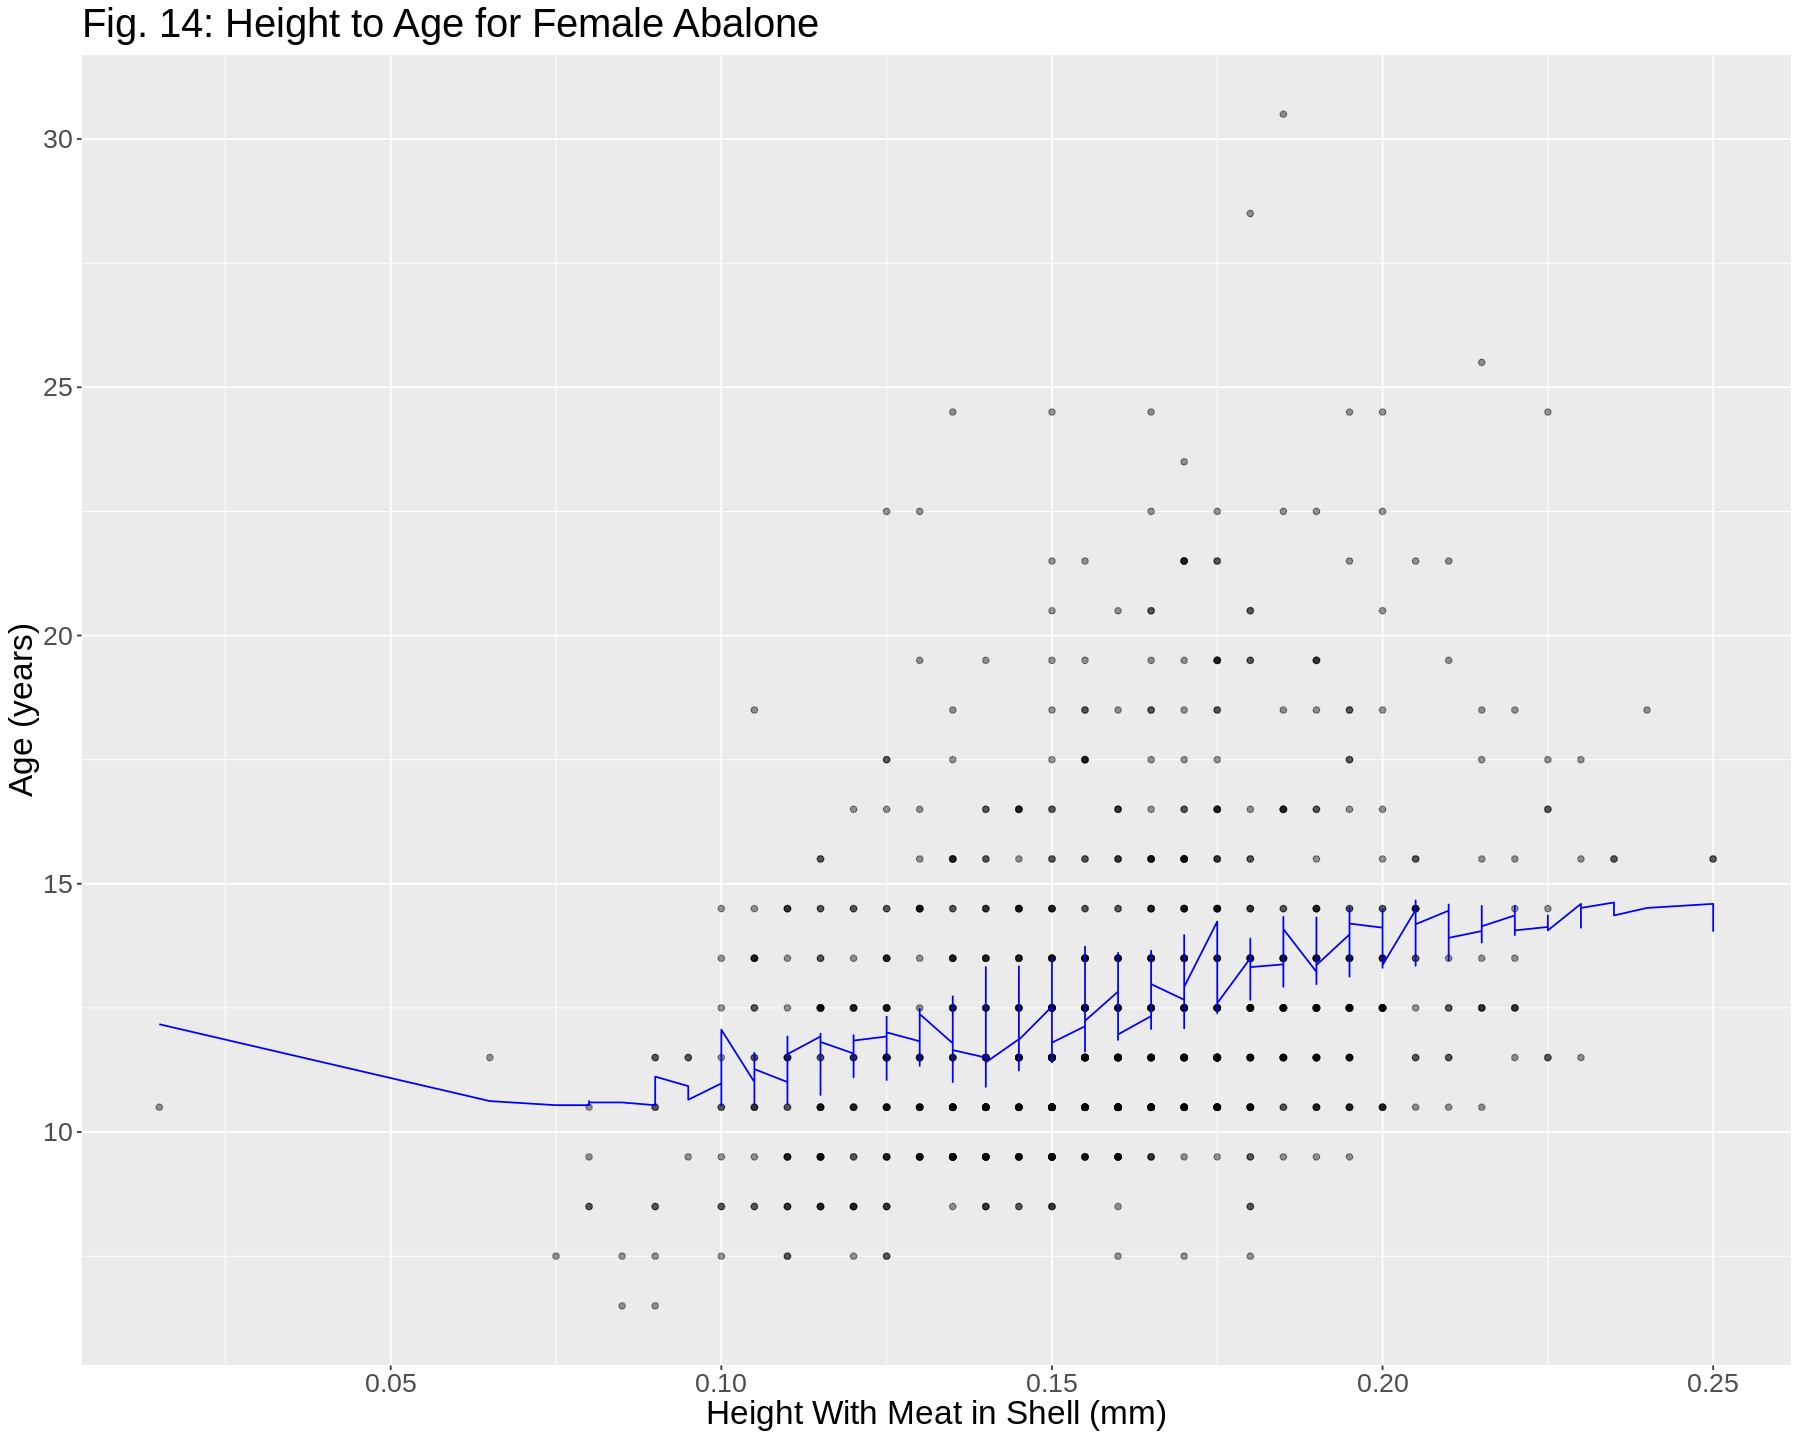

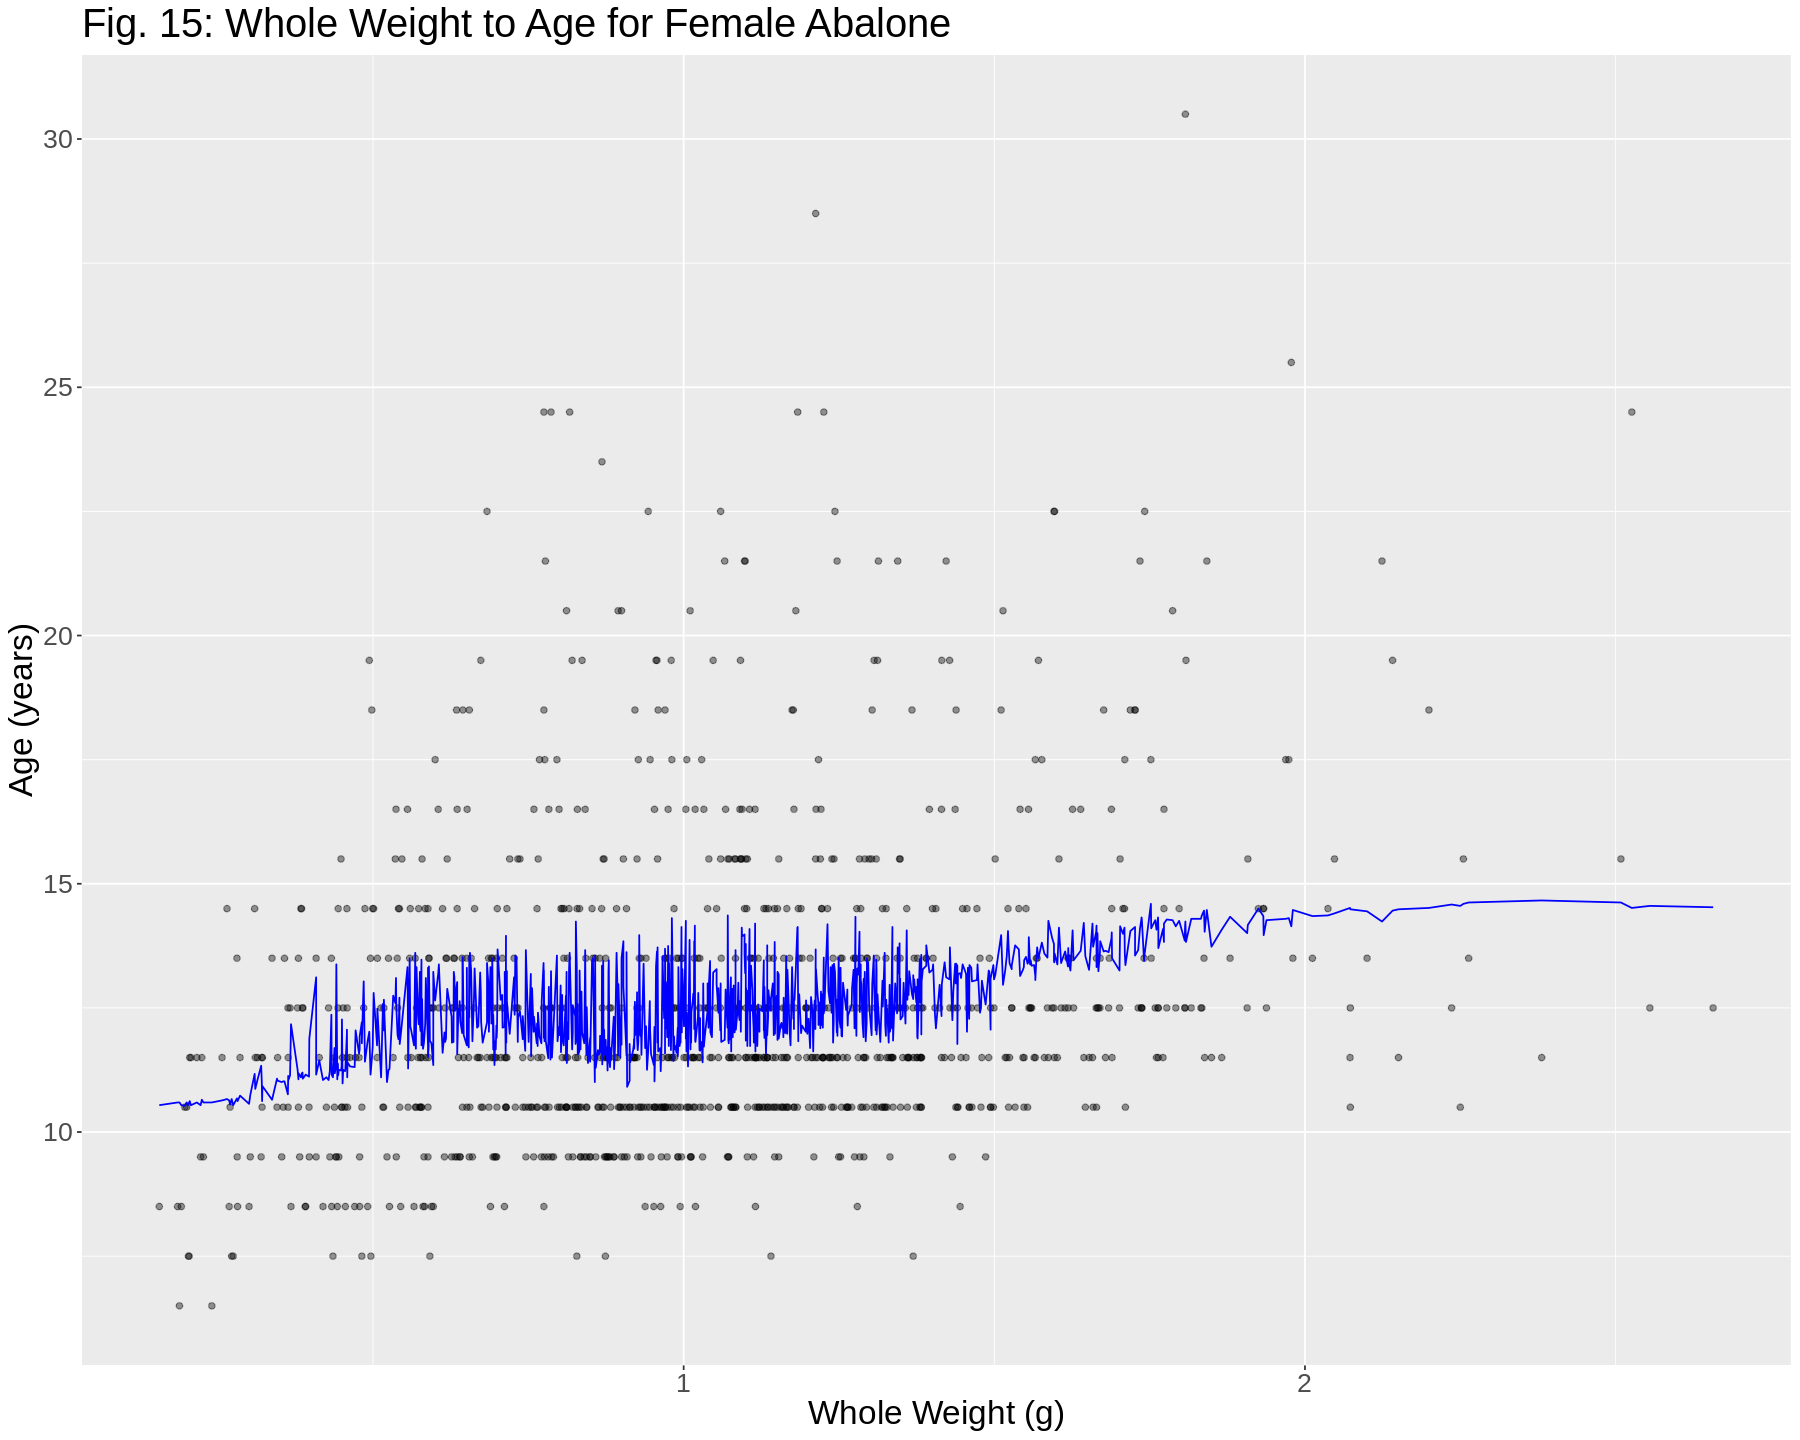

In [17]:
abalone_female_preds <- abalone_female_best_fit %>%
    predict(abalone_training_female) %>%
    bind_cols(abalone_training_female)

abalone_female_length_plot <- abalone_female_preds %>%
    ggplot(aes(x = length, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = length, y = .pred), color = "blue") +
    labs(x = "Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 12: Length to Age for Female Abalone") +
    theme(text = element_text(size=20))
abalone_female_length_plot

abalone_female_diameter_plot <- abalone_female_preds %>%
    ggplot(aes(x = diameter, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = diameter, y = .pred), color = "blue") +
    labs(x = "Length Perpendicular to Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 13: Diameter to Age for Female Abalone") +
    theme(text = element_text(size=20))
abalone_female_diameter_plot

abalone_female_height_plot <- abalone_female_preds %>%
    ggplot(aes(x = height, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = height, y = .pred), color = "blue") +
    labs(x = "Height With Meat in Shell (mm)", y = "Age (years)") +
    ggtitle("Fig. 14: Height to Age for Female Abalone") +
    theme(text = element_text(size=20))
abalone_female_height_plot

abalone_female_whole_plot <- abalone_female_preds %>%
    ggplot(aes(x = whole_weight, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = whole_weight, y = .pred), color = "blue") +
    labs(x = "Whole Weight (g)", y = "Age (years)") +
    ggtitle("Fig. 15: Whole Weight to Age for Female Abalone") +
    theme(text = element_text(size=20))
abalone_female_whole_plot

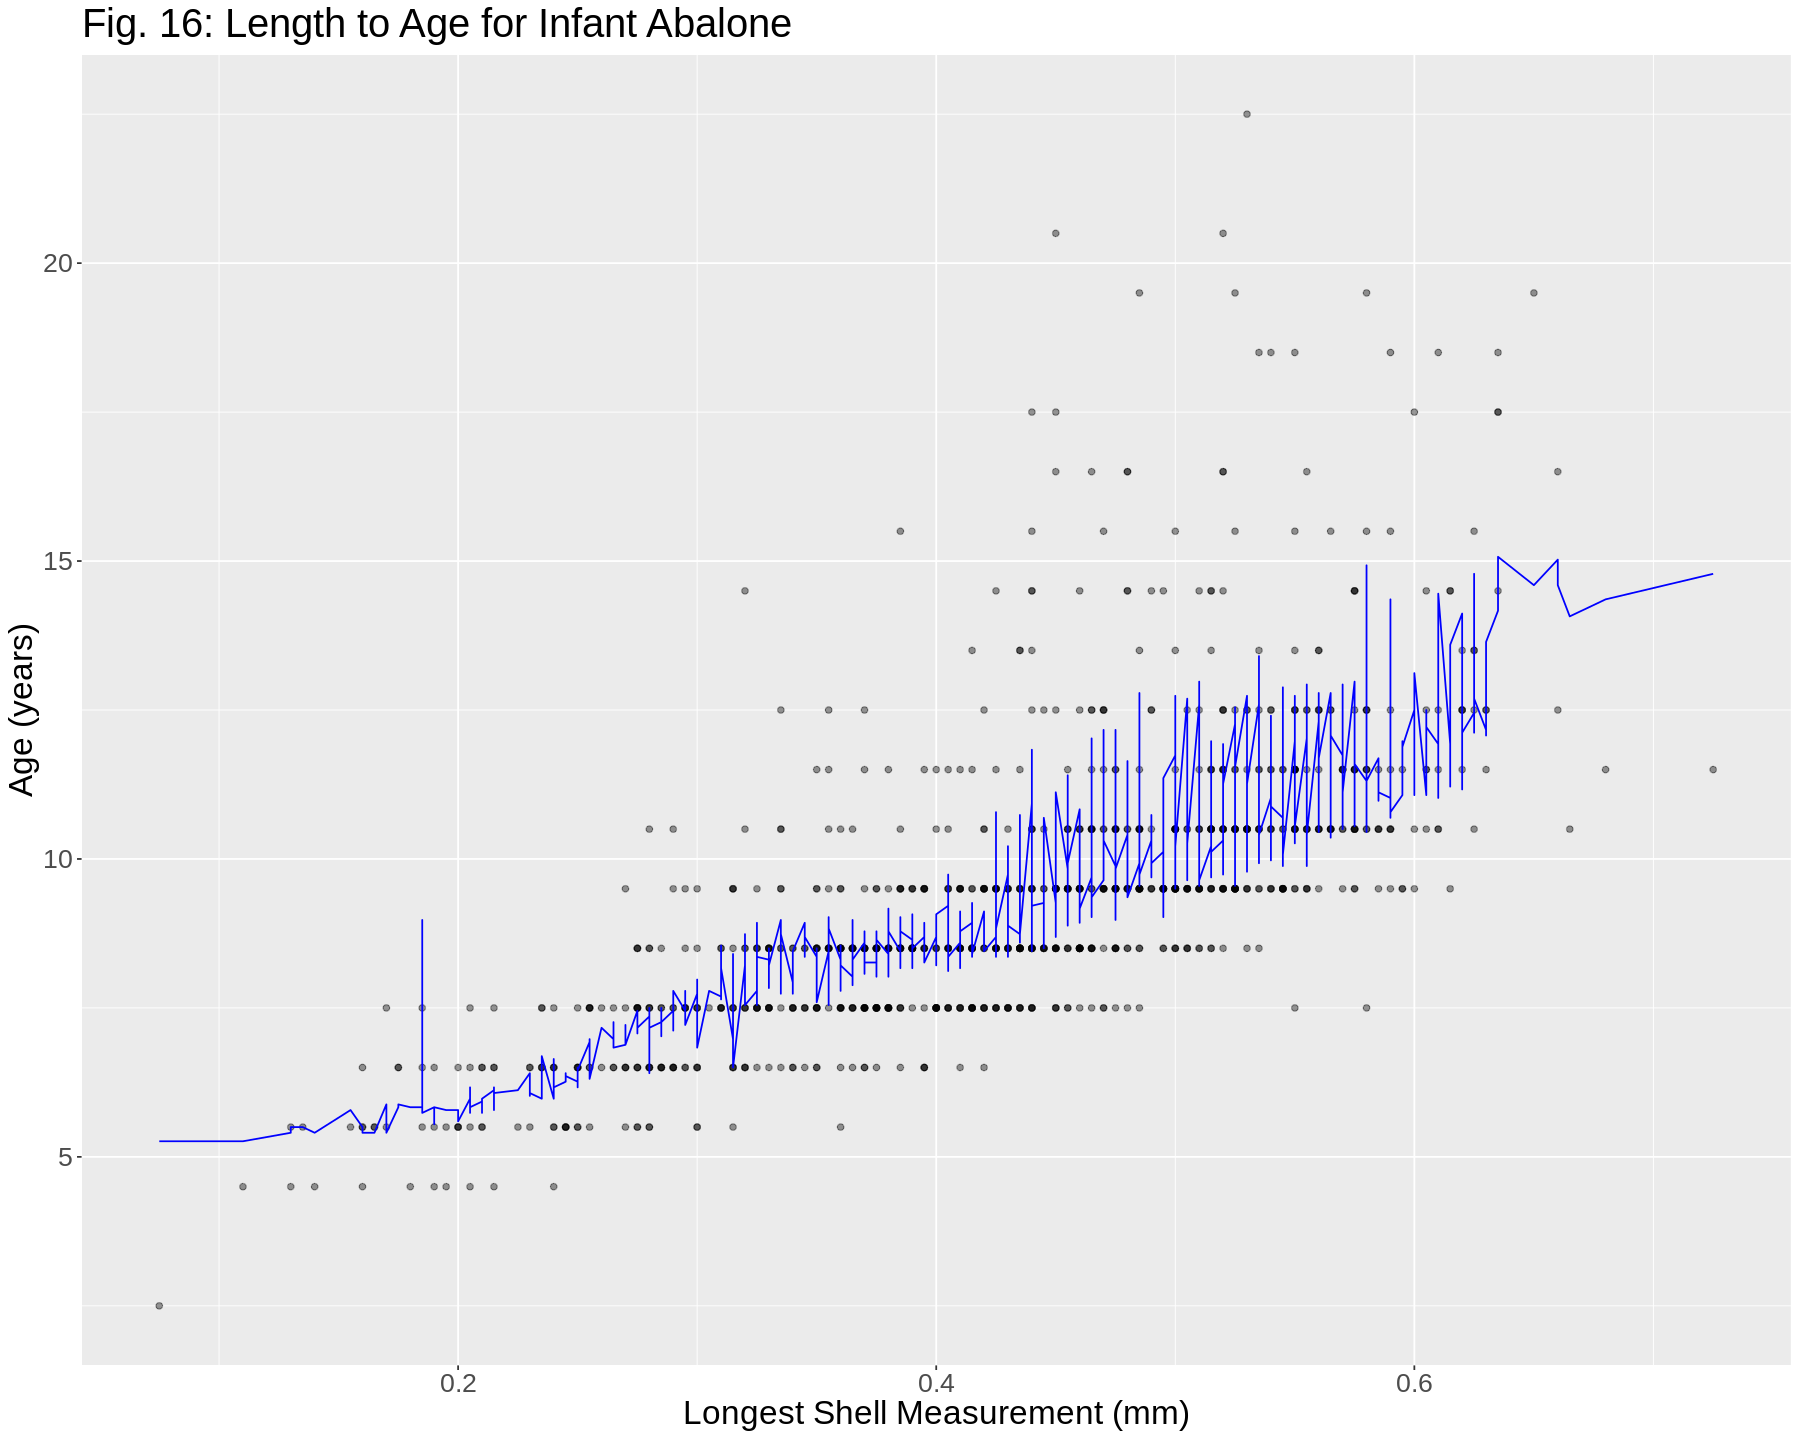

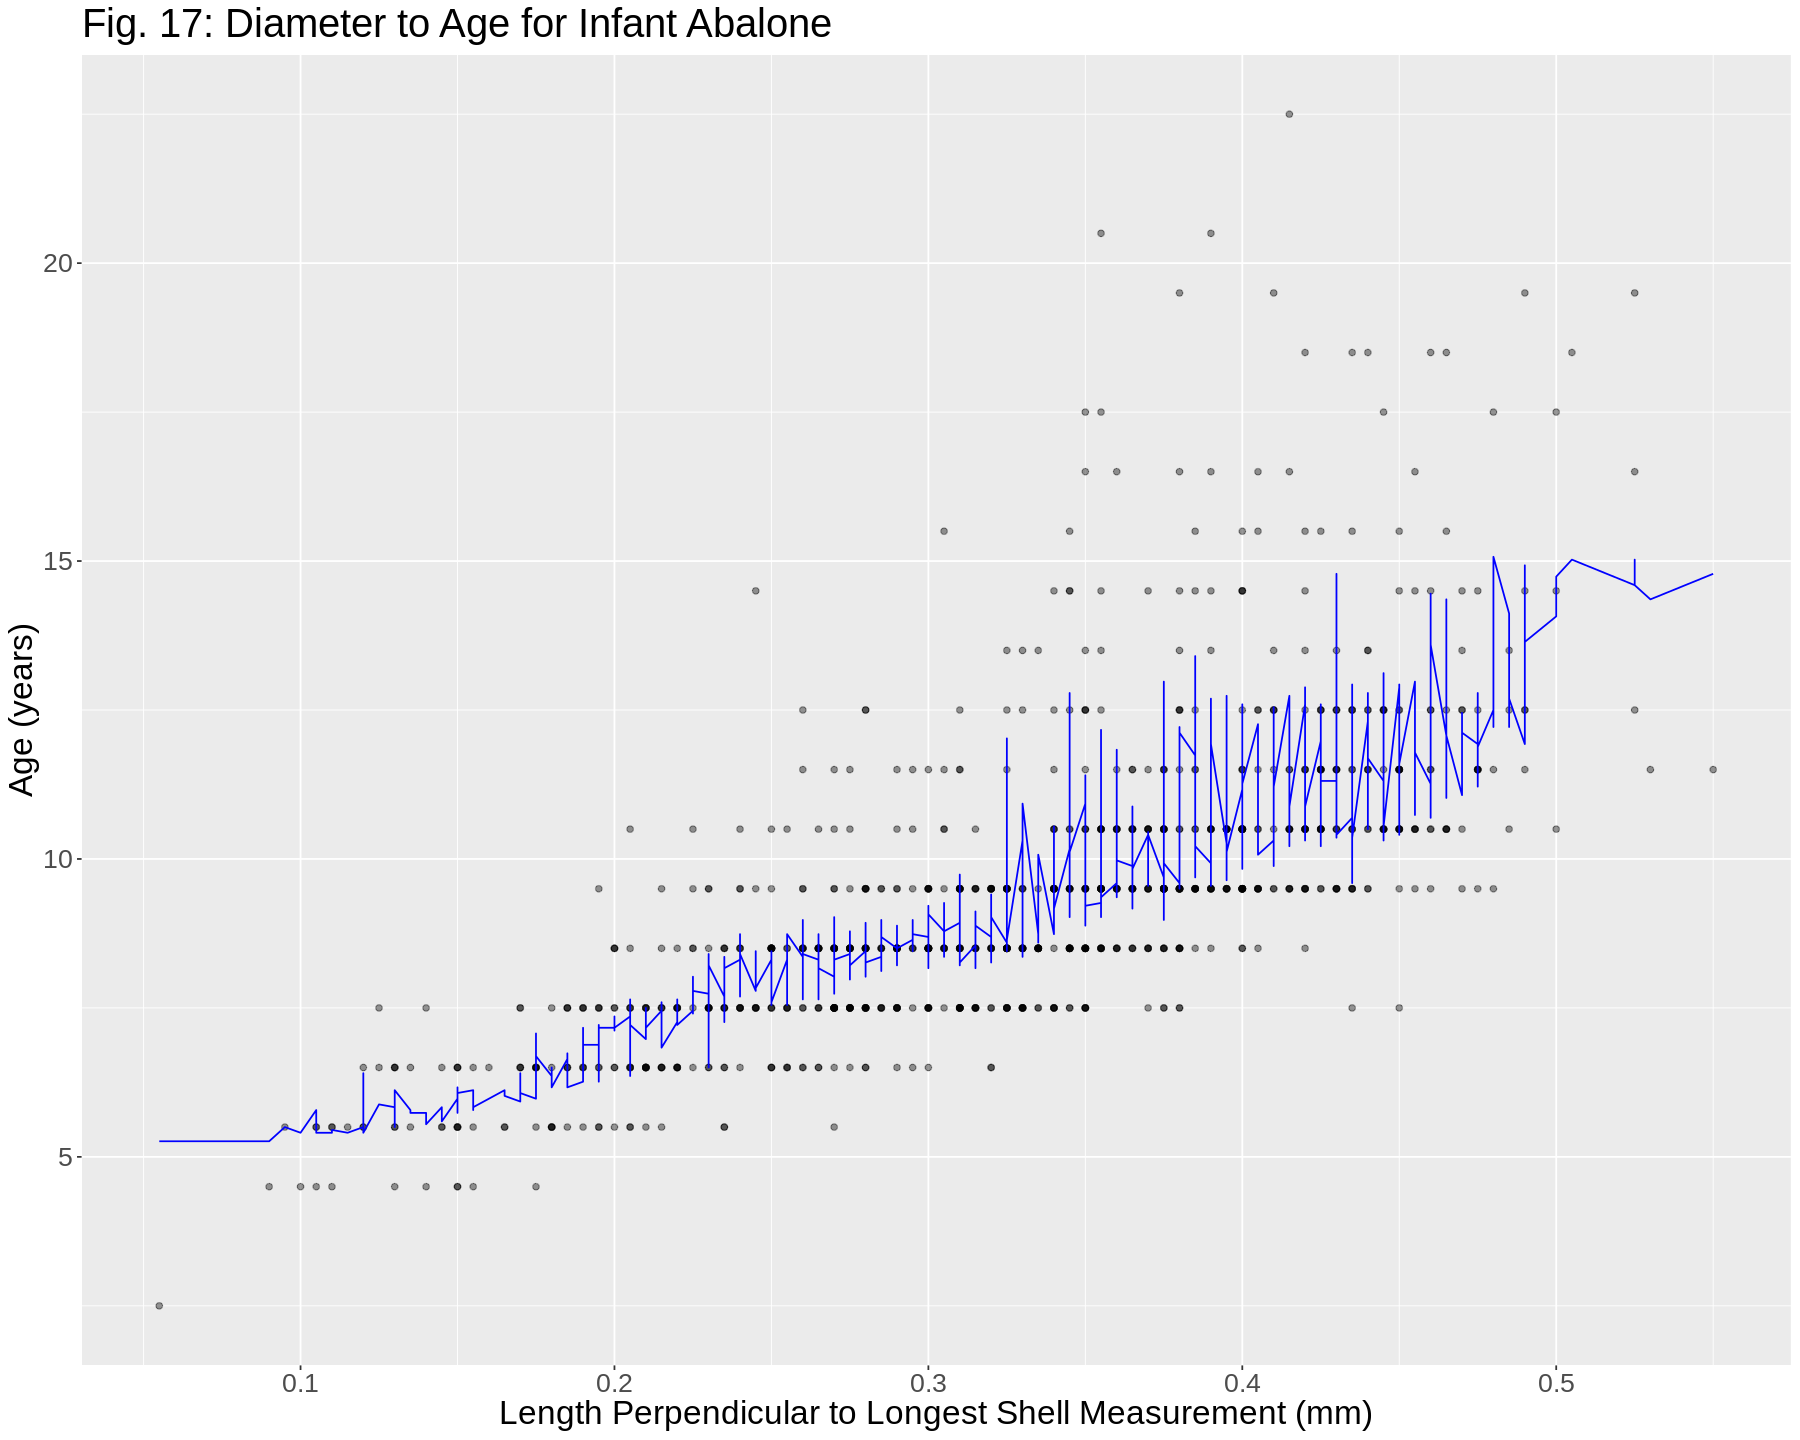

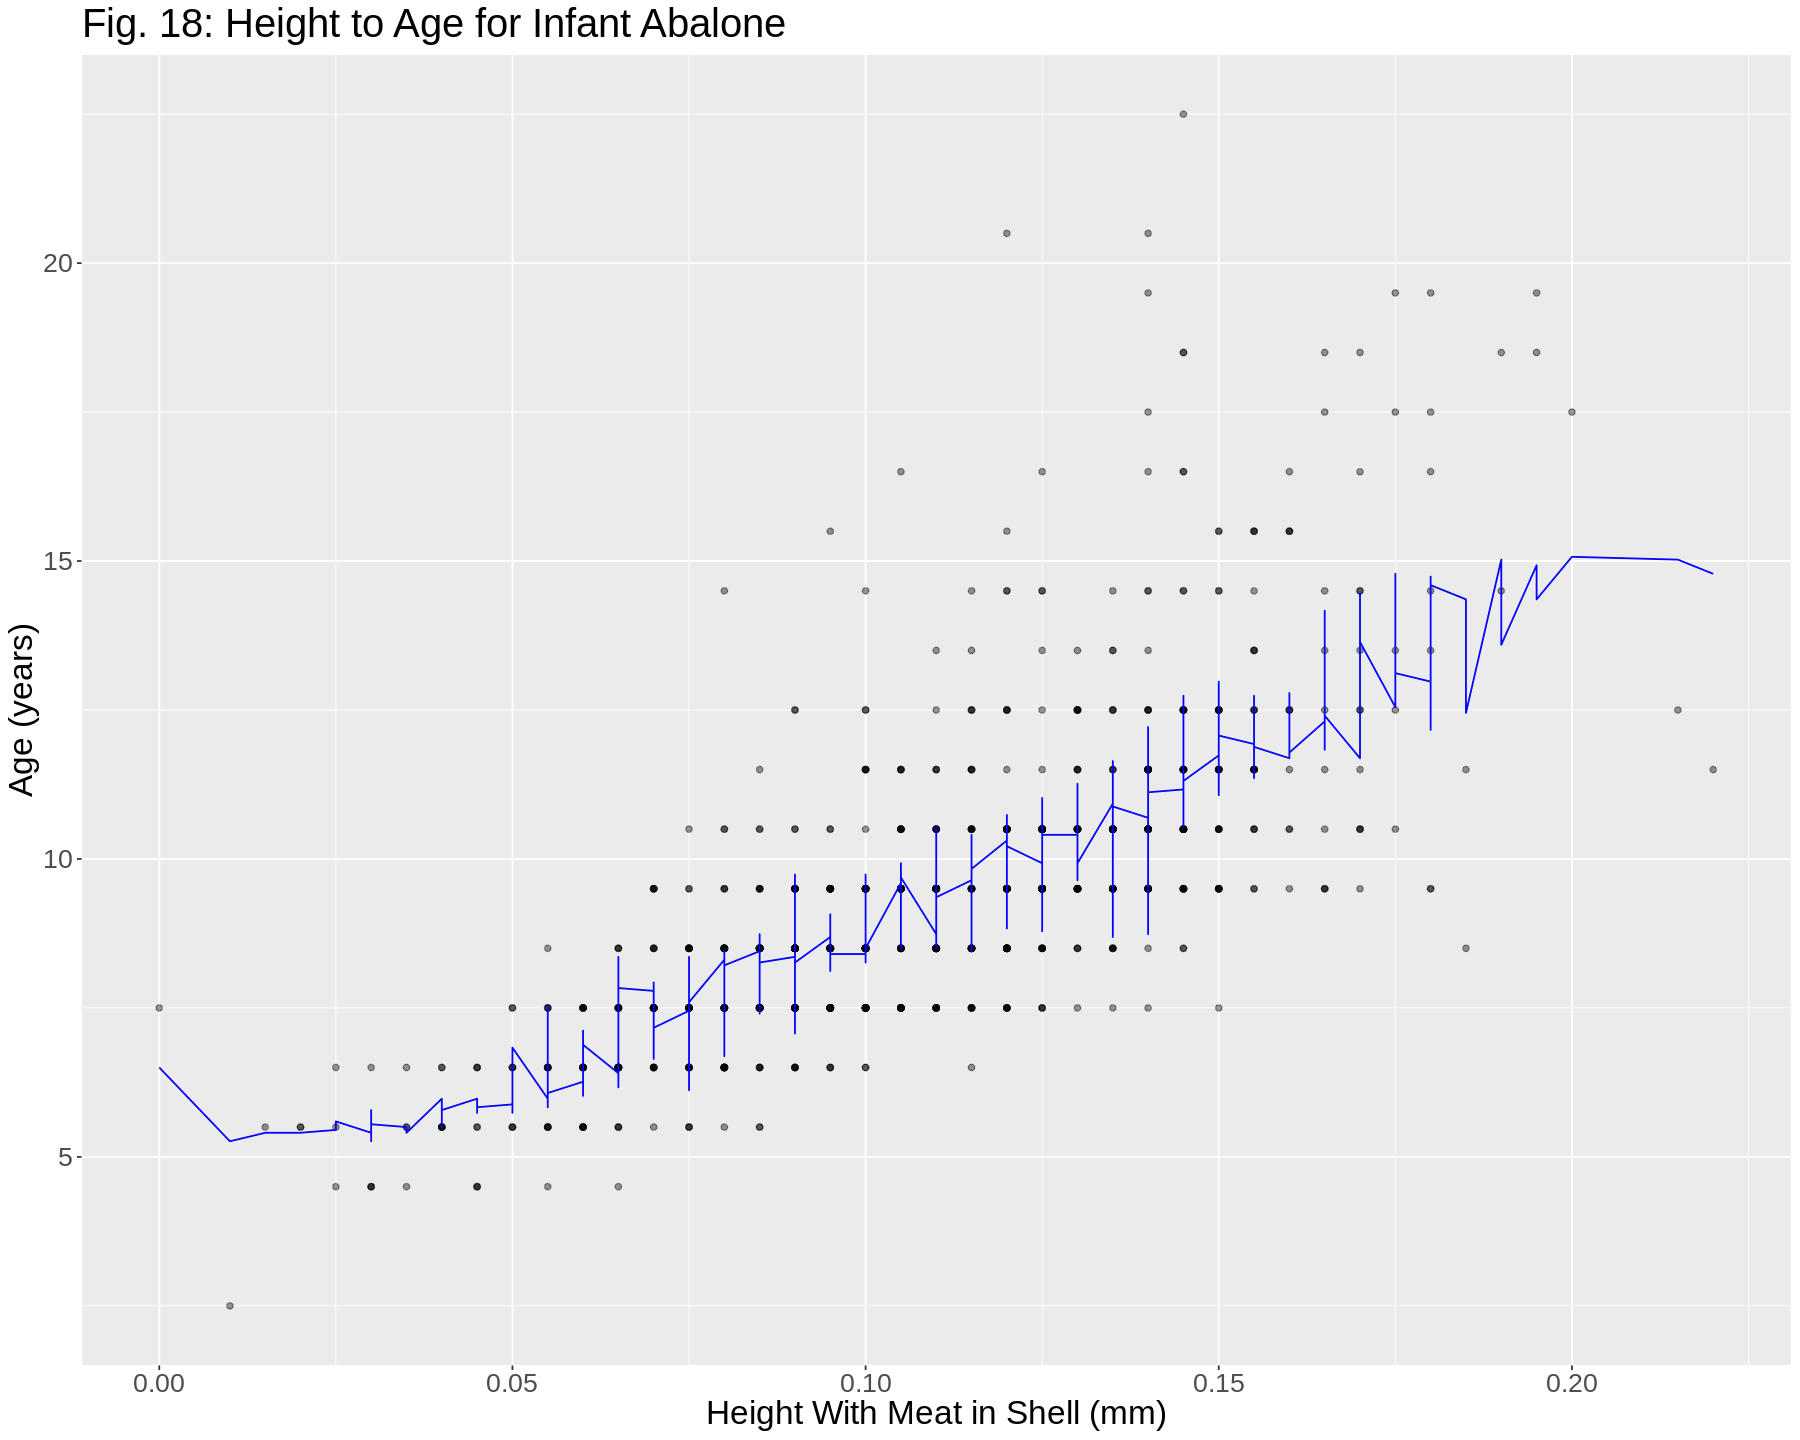

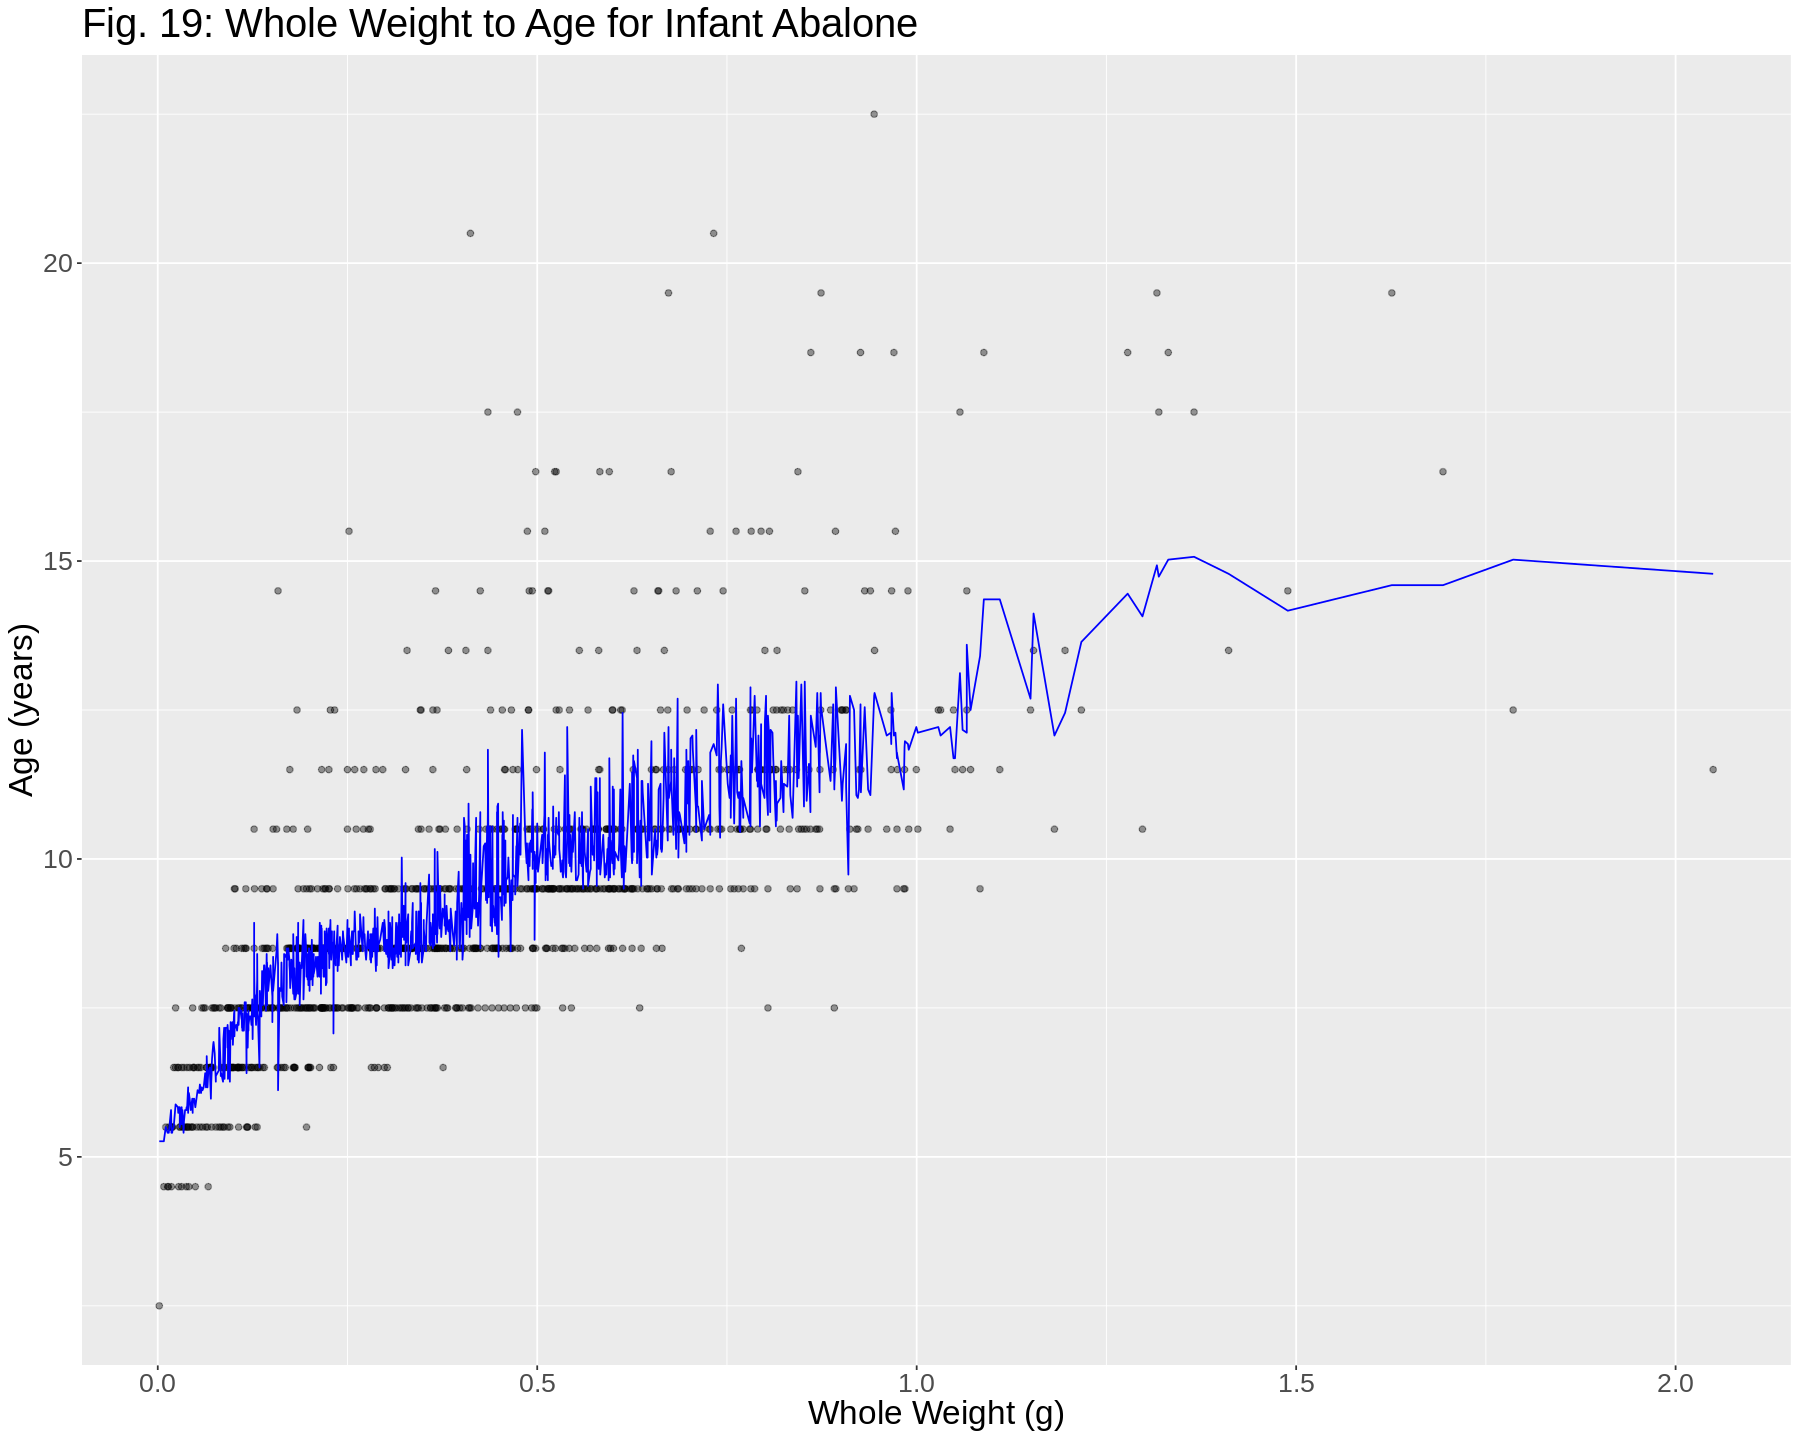

In [18]:
abalone_infant_preds <- abalone_infant_best_fit %>%
    predict(abalone_training_infant) %>%
    bind_cols(abalone_training_infant)

abalone_infant_length_plot <- abalone_infant_preds %>%
    ggplot(aes(x = length, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = length, y = .pred), color = "blue") +
    labs(x = "Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 16: Length to Age for Infant Abalone") +
    theme(text = element_text(size=20))
abalone_infant_length_plot

abalone_infant_diameter_plot <- abalone_infant_preds %>%
    ggplot(aes(x = diameter, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = diameter, y = .pred), color = "blue") +
    labs(x = "Length Perpendicular to Longest Shell Measurement (mm)", y = "Age (years)") +
    ggtitle("Fig. 17: Diameter to Age for Infant Abalone") +
    theme(text = element_text(size=20))
abalone_infant_diameter_plot

abalone_infant_height_plot <- abalone_infant_preds %>%
    ggplot(aes(x = height, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = height, y = .pred), color = "blue") +
    labs(x = "Height With Meat in Shell (mm)", y = "Age (years)") +
    ggtitle("Fig. 18: Height to Age for Infant Abalone") +
    theme(text = element_text(size=20))
abalone_infant_height_plot

abalone_infant_whole_plot <- abalone_infant_preds %>%
    ggplot(aes(x = whole_weight, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(aes(x = whole_weight, y = .pred), color = "blue") +
    labs(x = "Whole Weight (g)", y = "Age (years)") +
    ggtitle("Fig. 19: Whole Weight to Age for Infant Abalone") +
    theme(text = element_text(size=20))
abalone_infant_whole_plot

## Figure Legend

In [19]:
Figure <- seq(1:19)
Title <- c("Length to Age", "Diamater to Age", "Height to Age", "Whole Weight to Age", "Shucked Weight to Age", "Viscera Weight to Age", "Shell Weight to Age", "Length to Age for Male Abalone", "Diamater to Age for Male Abalone", "Height to Age for Male Abalone", "Whole Weight to Age for Male Abalone",  "Length to Age for Female Abalone", "Diamater to Age for Female Abalone", "Height to Age for Female Abalone", "Whole Weight to Age for Female Abalone",  "Length to Age for Infant Abalone", "Diamater to Age for Infant Abalone", "Height to Age for Infant Abalone", "Whole Weight to Age for Infant Abalone")
Legend <- tibble(Figure, Title)
Legend

Figure,Title
<int>,<chr>
1,Length to Age
2,Diamater to Age
3,Height to Age
4,Whole Weight to Age
5,Shucked Weight to Age
6,Viscera Weight to Age
7,Shell Weight to Age
8,Length to Age for Male Abalone
9,Diamater to Age for Male Abalone


## Discussion:

We expected to find older abalone to be larger and heavier than younger abalone of the same sex, as older abalone have more time to grow. Being that we used four predictors in our analysis, it is difficult to anticipate the complex relationship between all four predictors and our target variable, and thus we had no expectations of the accuracy of our model.

The data, and resulting fit of the models, was in line with what we expected regarding correlation between sex, age, and physical dimensions. One notable feature we failed to anticipate is the stronger positive relationship between age and physical size in infant abalones, likely because this is a period of more rapid growth. The RMSE of the models on our testing data sets are as follows: 2.7516865 for males, 2.8184456 for females, and 1.7185872 for infants. As expected from the stronger predictors with infants, there is a significantly lower RMSE when predicting infant abalone age. The infant testing set predictions had a mean absolute error (MAE) of 1.1392928, which is the average absolute difference between the predicted and actual values of the data set. This means that on average, our predictions were 1.14 years off from the true ages of the infants. We believe this is a relatively good result given the wide variety of sizes that abalone of the same age can come in.

A sufficiently accurate predictive model could potentially aid in the creation of more powerful tools to automate the assessment of abalone age. This could help farmers and sellers determine the market price of abalone, since their economic value is positively correlated with their respective ages (Misman et al.). Abalone fisheries are a rapidly growing industry——global production saw a 750% increase from 2010-2018 (Cook), which makes this task increasingly relevant.

Other researchers have utilized the same data set to create predictive models with lower RMSE's, such as Guo et al. and Misman et al, who used artificial neural networks rather than simple k-nn regression. This indicates that the data set has the capacity to yield highly accurate, and therefore useful, models through more sophisticated data analysis techniques. This, along with our own analysis, brings us to future questions we have regarding the topic:

* Which data analysis methods will yield the most accurate predictions of abalone age based off of physical dimensions?

* Given that physical dimensions worked best to predict infant abalone ages, what other measurements will be more useful to predict the ages of mature abalone?

* Will there be practical economic benefits to employing a computer-based system of identifying abalone age rather than human labor, which remains the industry standard?


## References

- Cook, P. (2014). The Worldwide Abalone Industry. *Modern Economy, 05(13)*, 1181-1186. https://doi.org/10.4236/me.2014.513110

- Guo, R., Luo, J., & Gao, W. (2021). A new method of measuring the age of abalone based on data visualization analysis. *Journal of Physics. Conference Series, 1744(4), 42181.* https://doi.org/10.1088/1742-6596/1744/4/042181

- Misman, M. F., Samah, A. A., Aziz, N. A. A., Majid, H. A., Shah, Z. A., Hashim, H., & Harun, M. F. (2019). *Prediction of abalone age using regression-based neural network.* 23-28. https://doi.org/10.1109/AiDAS47888.2019.8970983

- Nash, W., Sellers, T., Talbot, S., Cawthorn, A., & Ford, W. (1994). UCI Machine Learning Repository: Abalone Data Set. *Archive.ics.uci.edu.* https://archive.ics.uci.edu/ml/datasets/Abalone. 